![](https://cdn-images-1.medium.com/max/853/1*DgFPLm5TKXuKnNUlYCE2DQ.jpeg)

<div align='left'><font size='5' color='#5b2c6f '> Purpose of this notebook</font></div>

- In this notebook we will discuss about class imbalance problem which is occus often more in problems like fraudulent transaction identification and
  spam  identification .
- Discuss and implement methods to solve this issue to an extend.
- [Loading Libraries](#1)
- [Loading Data ](#2)
- [The metric trap](#3)
- [Data preparating](#4)
- [EDA - Zining Han](#5)
- [Feature Selection and Engineering - Zining Han](#6)
- [Resampling](#7)
- [Resampling using sklearn](#8)
- [Dimensionality Reduction and Clustering](#9)
- [Python imbalanced-learn module](#10)
- [Algorithmic Ensemble Techniques - Zining Han](#11)

## [Loading Required libraries](#1)<a id="1"></a> <br>

In [1]:
# !pip install -U vega_datasets notebook vega
# conda install py-xgboost

In [1]:
from datetime import datetime
start_time = datetime.now()
# %pip install xgboost
# %pip install imblearn
# %pip install openpyxl

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
import lightgbm as lgb
import time
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
from sklearn.metrics import confusion_matrix
import imblearn
import eli5
# import shap
import altair as alt
from altair.vega import v5
from IPython.display import HTML
from scipy import stats 
alt.renderers.enable('notebook')
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

print('LOAD DURATION:',datetime.now() - start_time) # about a minute

LOAD DURATION: 0:00:02.952704


## [Loading Data](#2)<a id="2"></a> <br>

In [2]:
%%time 
train_transactions=pd.read_csv('input/train_transaction.csv')
train_identity=pd.read_csv('input/train_identity.csv')
print('Train data set is loaded !')
test_transactions=pd.read_csv('input/test_transaction.csv')
test_identity=pd.read_csv('input/test_identity.csv')
print('Test data set is loaded !')

Train data set is loaded !
Test data set is loaded !
CPU times: user 35.2 s, sys: 12 s, total: 47.1 s
Wall time: 56.8 s


<div align='left'><font size='4' color='#229954'>Getting basic Idea</font></div>

In [3]:
train_transactions.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [5]:
train_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 1.7+ GB


In [5]:
train_identity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  144233 non-null  int64  
 1   id_01          144233 non-null  float64
 2   id_02          140872 non-null  float64
 3   id_03          66324 non-null   float64
 4   id_04          66324 non-null   float64
 5   id_05          136865 non-null  float64
 6   id_06          136865 non-null  float64
 7   id_07          5155 non-null    float64
 8   id_08          5155 non-null    float64
 9   id_09          74926 non-null   float64
 10  id_10          74926 non-null   float64
 11  id_11          140978 non-null  float64
 12  id_12          144233 non-null  object 
 13  id_13          127320 non-null  float64
 14  id_14          80044 non-null   float64
 15  id_15          140985 non-null  object 
 16  id_16          129340 non-null  object 
 17  id_17          139369 non-nul

In [6]:
test_transactions.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
test_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663586,-45,280290.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
1,3663588,0,3579.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 67.0 for android,24.0,1280x720,match_status:2,T,F,T,T,mobile,LGLS676 Build/MXB48T
2,3663597,-5,185210.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,...,ie 11.0 for tablet,NaN,NaN,NaN,F,T,T,F,desktop,Trident/7.0
3,3663601,-45,252944.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
4,3663602,-95,328680.0,NaN,NaN,7.0,-33.0,NaN,NaN,NaN,...,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,SM-G9650 Build/R16NW


In [8]:
# test_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506691 entries, 0 to 506690
Columns: 393 entries, TransactionID to V339
dtypes: float64(376), int64(3), object(14)
memory usage: 1.5+ GB


In [139]:
# test_identity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141907 entries, 0 to 141906
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  141907 non-null  int64  
 1   id_01          141907 non-null  int64  
 2   id_02          136976 non-null  float64
 3   id_03          66481 non-null   float64
 4   id_04          66481 non-null   float64
 5   id_05          134750 non-null  float64
 6   id_06          134750 non-null  float64
 7   id_07          5059 non-null    float64
 8   id_08          5059 non-null    float64
 9   id_09          74338 non-null   float64
 10  id_10          74338 non-null   float64
 11  id_11          136778 non-null  float64
 12  id_12          141907 non-null  object 
 13  id_13          130286 non-null  float64
 14  id_14          71357 non-null   float64
 15  id_15          136977 non-null  object 
 16  id_16          125747 non-null  object 
 17  id_17          135966 non-nul

## [The metric trap](#3)<a id="3"></a> <br>
    

One of the major issues that novice users fall into when dealing with unbalanced datasets relates to the metrics used to evaluate their model. Using simpler metrics like accuracy_score can be misleading. In a dataset with highly unbalanced classes, if the classifier always "predicts" the most common class without performing any analysis of the features, it will still have a high accuracy rate, obviously illusory.


    False Positive. Predict an event when there was no event.
    False Negative. Predict no event when in fact there was an event.

   In the overview of the problem statement the organizers has described a situation where you stand at the queue for a long time and when your chance arrives,the transaction gets denied because it was interpreted as a Fraudulent transaction which many of us have faced.
 This is classical example of **False Negative** prediction.
 


**Change the performance metric**

As we saw above, accuracy is not the best metric to use when evaluating imbalanced datasets as it can be very misleading. Metrics that can provide better insight include:

**Confusion Matrix**: a table showing correct predictions and types of incorrect predictions.
    
**Precision**: the number of true positives divided by all positive predictions. Precision is also called Positive Predictive Value. It is a measure of a classifier’s exactness. Low precision indicates a high number of false positives.
    
**Recall**: the number of true positives divided by the number of positive values in the test data. Recall is also called Sensitivity or the True Positive Rate. It is a measure of a classifier’s completeness. Low recall indicates a high number of false negatives.
    
**F1 Score**: the weighted average of precision and recall.

I don't understand why the competition hosts selected ROC_AUC as evaluation metric,I think
- ROC curves should be used when there are roughly equal numbers of observations for each class.
-  Precision-Recall curves should be used when there is a moderate to large class imbalance.


## [Merging transaction and identity dataset](#4)<a id="4"></a> <br>


We will first merge our **transactions** and **identity** datasets.

In [104]:
# train = train_transactions.merge(train_identity, how='left', left_index=True, right_index=True)
train = pd.merge(train_transactions, train_identity, on='TransactionID', how='left')
print('Train shape',train.shape)
print("Train Data set merged ")

Train shape (590540, 434)
Train Data set merged 


In [10]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [11]:
test = pd.merge(test_transactions, test_identity, on='TransactionID', how='left')
print('Test shape',train.shape)
print("Test Data set merged ")

Test shape (590540, 434)
Test Data set merged 


In [12]:
test.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
# train.info()
# test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 435 entries, TransactionID_x to DeviceInfo
dtypes: float64(400), int64(4), object(31)
memory usage: 1.9+ GB


<div align='left'><font size='4' color='#229954'>Reducing memory usage</font></div>



In [13]:
%%time
# From kernel https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
# WARNING! THIS CAN DAMAGE THE DATA 
def reduce_mem_usage2(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 9.06 µs


In [14]:
%%time
train = reduce_mem_usage2(train)

Memory usage of dataframe is 1959.88 MB
Memory usage after optimization is: 530.06 MB
Decreased by 73.0%
CPU times: user 1min 30s, sys: 1min 39s, total: 3min 10s
Wall time: 3min 56s


In [15]:
%%time
test = reduce_mem_usage2(test)

Memory usage of dataframe is 1677.73 MB
Memory usage after optimization is: 462.06 MB
Decreased by 72.5%
CPU times: user 1min 22s, sys: 1min 25s, total: 2min 47s
Wall time: 3min 32s


In [12]:
# train.to_excel('train_all_comp.xlsx',index=False)

<div align='left'><font size='4' color='#229954'>Splitting to train and validation</font></div>

- We will now split the train dataset into train and validation set.
- We will keeep 20% of data for validation.

In [ ]:
# X_train,X_test,y_train,y_test=train_test_split(train.drop('isFraud',axis=1),train['isFraud'],test_size=.2,random_state=1)

## [EDA - Zining Han](#5)<a id="5"></a> <br>

We will use the merged dataset called 'train' and consider it as a bunch of more fields for the EDA and our further analysis.

### Overview

In [16]:
# gain an overview of the dataset
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: category(31), float16(354), float32(45), int16(1), int32(2), int8(1)
memory usage: 530.1 MB


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [17]:
# get the summary statistics of all numerical fields
train.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.0,588975.0,586281.0,524834.0,524834.0,...,139369.0,4.511300e+04,139318.0,139261.0,5159.0,5169.000000,4747.000000,5132.0000,5163.00000,77586.0
mean,3.282270e+06,0.034990,7.372311e+06,NaN,9898.734658,NaN,NaN,NaN,NaN,NaN,...,NaN,inf,NaN,NaN,inf,inf,12.820312,inf,inf,NaN
std,1.704744e+05,0.183755,4.617224e+06,NaN,4901.170153,NaN,0.0,0.0,NaN,0.0,...,0.0,1.561523e+00,NaN,NaN,inf,6.898438,2.371094,97.4375,32.09375,0.0
min,2.987000e+06,0.000000,8.640000e+04,0.250977,1000.000000,100.0,100.0,100.0,100.0,10.0,...,100.0,1.000000e+01,100.0,100.0,100.0,10.000000,11.000000,100.0000,100.00000,0.0
25%,3.134635e+06,0.000000,3.027058e+06,43.312500,6019.000000,214.0,150.0,166.0,204.0,87.0,...,166.0,1.300000e+01,266.0,256.0,252.0,14.000000,11.000000,321.0000,119.00000,24.0
50%,3.282270e+06,0.000000,7.306528e+06,68.750000,9678.000000,361.0,150.0,226.0,299.0,87.0,...,166.0,1.500000e+01,341.0,472.0,252.0,14.000000,11.000000,321.0000,149.00000,24.0
75%,3.429904e+06,0.000000,1.124662e+07,125.000000,14184.000000,512.0,150.0,226.0,330.0,87.0,...,225.0,1.500000e+01,427.0,533.0,486.5,14.000000,15.000000,371.0000,169.00000,32.0
max,3.577539e+06,1.000000,1.581113e+07,31936.000000,18396.000000,600.0,231.0,237.0,540.0,102.0,...,229.0,2.900000e+01,671.0,661.0,854.0,44.000000,26.000000,548.0000,216.00000,32.0


### Response Variable


From the plots, we can see there exists a class imbalace problem, since only 3.5% of the total transactions are labelled as fraudulent which only takes up 3.86% of the total transaction amount.


Text(0.5, 1.0, 'isFraud Count')

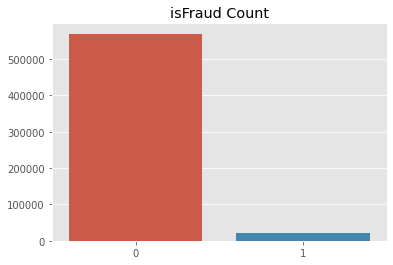

In [18]:
# There is clearly a class imbalace problem
x=train['isFraud'].value_counts().values
sns.barplot([0,1],x).set_title('isFraud Count')

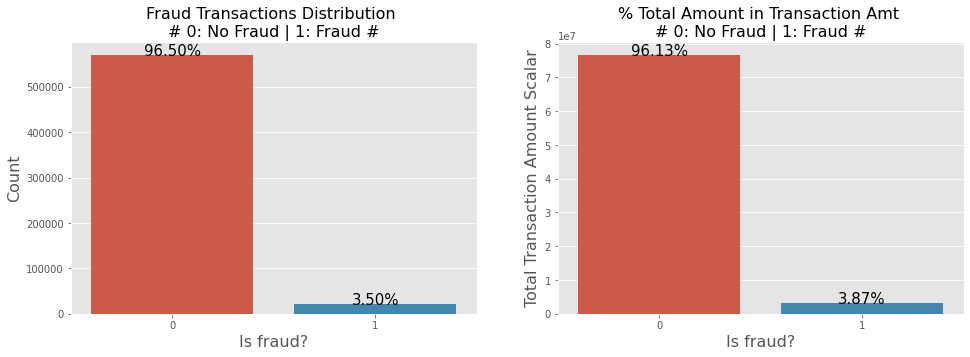

In [19]:
# isFraud with Transaction Amount
train_transactions['TransactionAmt'] = train_transactions['TransactionAmt'].astype(float)
total = len(train_transactions)
total_amt = train_transactions.groupby(['isFraud'])['TransactionAmt'].sum().sum()
plt.figure(figsize=(16,5))

plt.subplot(121)
g = sns.countplot(x='isFraud', data=train_transactions, )
g.set_title("Fraud Transactions Distribution \n# 0: No Fraud | 1: Fraud #", fontsize=16)
g.set_xlabel("Is fraud?", fontsize=16)
g.set_ylabel('Count', fontsize=16)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=15) 

perc_amt = (train_transactions.groupby(['isFraud'])['TransactionAmt'].sum())
perc_amt = perc_amt.reset_index()
plt.subplot(122)
g1 = sns.barplot(x='isFraud', y='TransactionAmt',  dodge=True, data=perc_amt)
g1.set_title("% Total Amount in Transaction Amt \n# 0: No Fraud | 1: Fraud #", fontsize=16)
g1.set_xlabel("Is fraud?", fontsize=16)
g1.set_ylabel('Total Transaction Amount Scalar', fontsize=16)
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total_amt * 100),
            ha="center", fontsize=15) 
    
plt.show()

### Transaction Amount

In [21]:
# learn about the distribution: exist outliers 
train['TransactionAmt'] = train['TransactionAmt'].astype(float)
print("Transaction Amounts Quantiles:")
print(train['TransactionAmt'].quantile([0,.01, .025, .1, .25, .5, .75, .9, .975, .99,1]))

Transaction Amounts Quantiles:
0.000        0.250977
0.010        9.242188
0.025       14.500000
0.100       25.953125
0.250       43.312500
0.500       68.750000
0.750      125.000000
0.900      275.250000
0.975      648.262500
0.990     1104.000000
1.000    31936.000000
Name: TransactionAmt, dtype: float64


In [22]:
# transaction amount quantiles of fraud and non-fraud transactions
print(pd.concat([train[train['isFraud'] == 1]['TransactionAmt']\
                 .quantile([0,.01, .1, .25, .5, .75, .9, .99,1])\
                 .reset_index(), 
                 train[train['isFraud'] == 0]['TransactionAmt']\
                 .quantile([0,.01, .1, .25, .5, .75, .9, .99,1])\
                 .reset_index()],
                axis=1, keys=['Fraud', "No Fraud"]))

  Fraud                No Fraud               
  index TransactionAmt    index TransactionAmt
0  0.00       0.291992     0.00       0.250977
1  0.01       6.739453     0.01       9.511875
2  0.10      18.937500     0.10      26.312500
3  0.25      35.031250     0.25      43.968750
4  0.50      75.000000     0.50      68.500000
5  0.75     161.000000     0.75     120.000000
6  0.90     335.000000     0.90     267.100000
7  0.99     994.000000     0.99    1104.000000
8  1.00    5192.000000     1.00   31936.000000


<AxesSubplot:ylabel='TransactionAmt'>

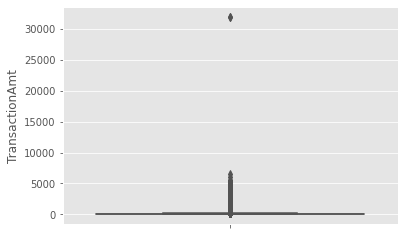

In [23]:
# we can clearly see outliers which stop us from learning more about the distribution
sns.boxplot(y=train['TransactionAmt'])

<AxesSubplot:xlabel='TransactionAmt', ylabel='Density'>

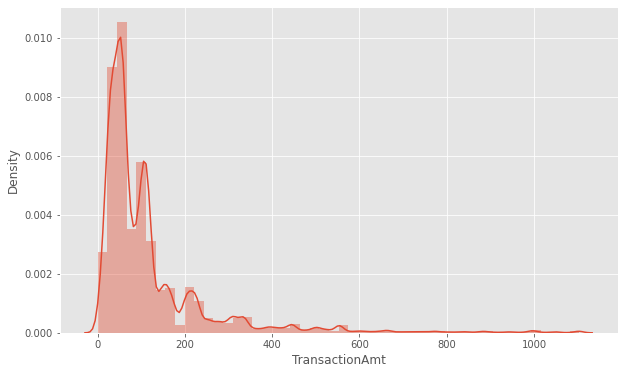

In [24]:
# remove outliers by taking a subset of the 99% percentile as cutoff
# we can see from the histgran that transaction amount if right skewed
df=train[train['TransactionAmt']<=1104]
plt.figure(figsize=(10, 6))
sns.distplot(df['TransactionAmt'])

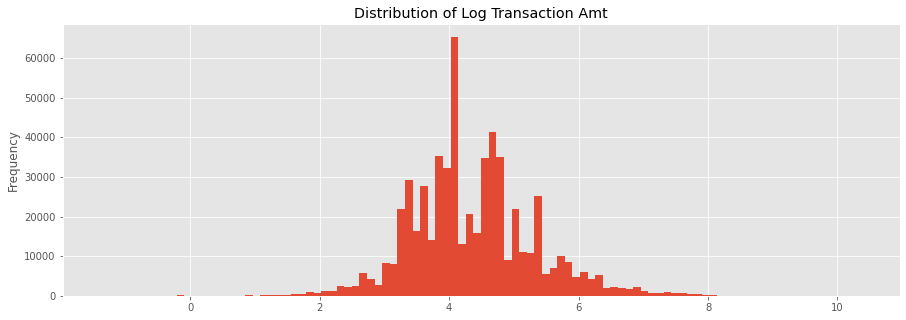

In [25]:
# take a log transformation to make it look better
train['TransactionAmt'] \
    .apply(np.log) \
    .plot(kind='hist',
          bins=100,
          figsize=(15, 5),
          title='Distribution of Log Transaction Amt')

plt.show()

In [26]:
# average transaction amount for fraud and non-fraud groups
print('Mean transaction amt for non-fraud is',train.groupby(['isFraud']).mean()['TransactionAmt'][0])
print('Mean transaction amt for fraud is',train.groupby(['isFraud']).mean()['TransactionAmt'][1])

Mean transaction amt for non-fraud is 134.51185725859278
Mean transaction amt for fraud is 149.24435261605134


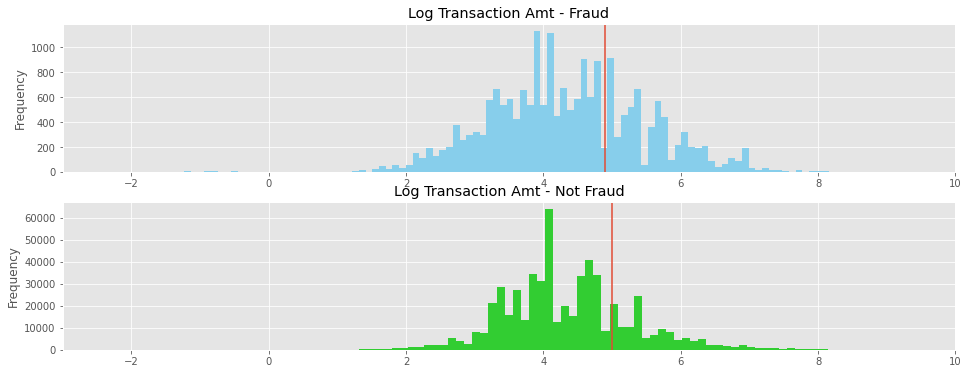

In [31]:
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(16, 6))
train.loc[train['isFraud'] == 1] \
    ['TransactionAmt'].apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='Log Transaction Amt - Fraud',
          xlim=(-3, 10),
          color='skyblue',
         ax=ax1).axvline(np.log(train.groupby(['isFraud']).mean()['TransactionAmt'][0]))

train.loc[train['isFraud'] == 0] \
    ['TransactionAmt'].apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='Log Transaction Amt - Not Fraud',
          xlim=(-3, 10),
          color='sesgreen',
         ax=ax2).axvline(np.log(train.groupby(['isFraud']).mean()['TransactionAmt'][1]))

### Transaction DT

The TransactionDT feature is a timedelta from a given reference datetime (not an actual timestamp). One early discovery about the data is that the train and test appear to be split by time. There is a slight gap inbetween, but otherwise the training set is from an earlier period of time and test is from a later period of time. This will impact which cross validation techniques should be used.

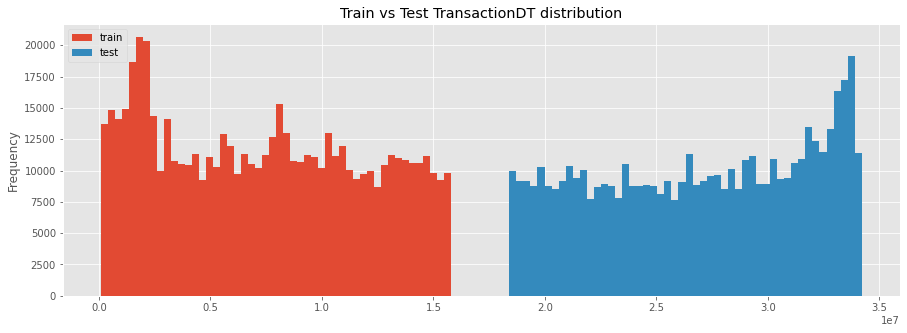

In [201]:
train['TransactionDT'].plot(kind='hist',
                                        figsize=(15, 5),
                                        label='train',
                                        bins=50,
                                        title='Train vs Test TransactionDT distribution')
test['TransactionDT'].plot(kind='hist',
                                       label='test',
                                       bins=50)
plt.legend()
plt.show()

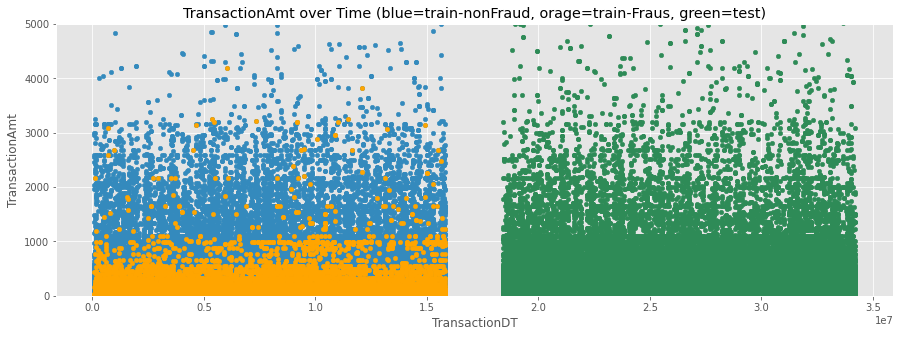

In [96]:
ax = train.plot(x='TransactionDT',
               y='TransactionAmt',
               kind='scatter',
               alpha=1,
               title='TransactionAmt over Time (blue=train-nonFraud, orage=train-Fraus, green=test)',
               ylim=(0, 5000),
               figsize=(15, 5))

test.plot(x='TransactionDT',
          y='TransactionAmt',
          kind='scatter',
          alpha=1,
          color='seagreen',
          ylim=(0, 5000),
          ax=ax)

# Plot Fraud as Orange
train.loc[train['isFraud'] == 1] \
    .plot(x='TransactionDT',
         y='TransactionAmt',
         kind='scatter',
         alpha=1,
         ylim=(0, 5000),
         color='orange',
         figsize=(15, 5),
         ax=ax)
plt.show()

### ProductCD

- For now we don't know exactly what these values represent.
- W has the most number of observations, C the least.
- ProductCD C has the most fraud with >11%
- ProductCD W has the least with ~2%

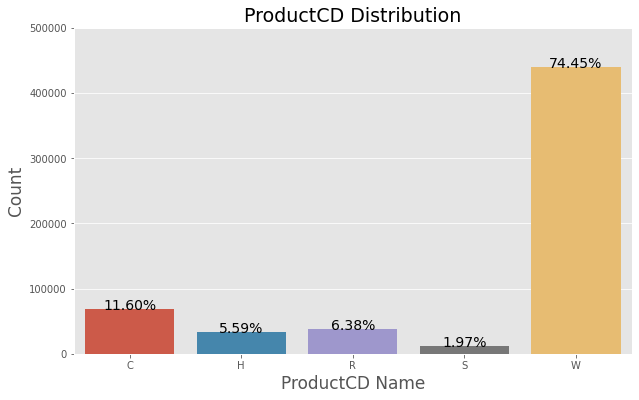

In [158]:
plt.figure(figsize=(10,6))
g = sns.countplot(x='ProductCD', data=train)
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])

g.set_title("ProductCD Distribution", fontsize=19)
g.set_xlabel("ProductCD Name", fontsize=17)
g.set_ylabel("Count", fontsize=17)
g.set_ylim(0,500000)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 

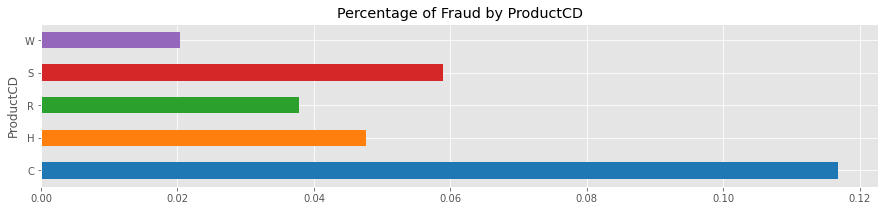

In [133]:
ax=train.groupby('ProductCD')['isFraud'] \
    .mean() \
    .sort_index() \
    .plot(kind='barh',
          figsize=(15, 3),
         title='Percentage of Fraud by Product Code', color=sns.color_palette("tab10"))

plt.show()

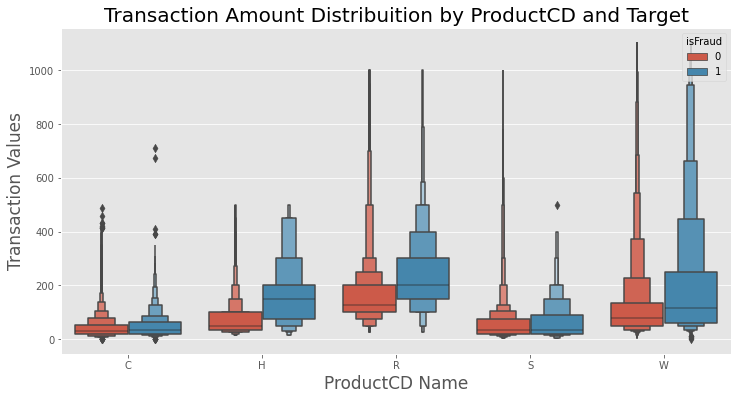

In [35]:
plt.figure(figsize=(12,6))
g3 = sns.boxenplot(x='ProductCD', y='TransactionAmt', hue='isFraud', 
              data=train[train['TransactionAmt'] <= 1104] )
g3.set_title("Transaction Amount Distribuition by ProductCD and Target", fontsize=20)
g3.set_xlabel("ProductCD Name", fontsize=17)
g3.set_ylabel("Transaction Values", fontsize=17)
plt.show()

### Card 1-6

In [56]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values   
    summary['% populated'] = 1- (df.isna().sum().values/len(df))
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

In [57]:
# overview
resumetable(train[['card1', 'card2', 'card3','card4', 'card5', 'card6']])

Dataset Shape: (590540, 6)


,Name,dtypes,Missing,% populated,Uniques,First Value,Second Value,Third Value,Entropy
0,card1,int16,0,1.000000,13553,13926,2755,4663,9.97
1,card2,float16,8933,0.984873,500,NaN,404.0,490.0,6.32
2,card3,float16,1565,0.997350,114,150.0,150.0,150.0,0.68
3,card4,category,1577,0.997330,4,discover,mastercard,visa,1.09
4,card5,float16,4259,0.992788,119,142.0,102.0,166.0,2.66
5,card6,category,1571,0.997340,4,credit,credit,debit,0.82


#### Numerical: Card 1,2,3,5

In [37]:
print("Card Features Quantiles: ")
print(train[['card1', 'card2', 'card3', 'card5']].quantile([0,0.01, .025, .1, .25, .5, .75, .975, .99,1]))

Card Features Quantiles: 
         card1  card2  card3  card5
0.000   1000.0  100.0  100.0  100.0
0.010   1338.0  100.0  144.0  102.0
0.025   1675.0  111.0  150.0  102.0
0.100   2803.0  111.0  150.0  126.0
0.250   6019.0  214.0  150.0  166.0
0.500   9678.0  361.0  150.0  226.0
0.750  14184.0  512.0  150.0  226.0
0.975  18018.0  583.0  185.0  226.0
0.990  18238.0  583.0  185.0  226.0
1.000  18396.0  600.0  231.0  237.0


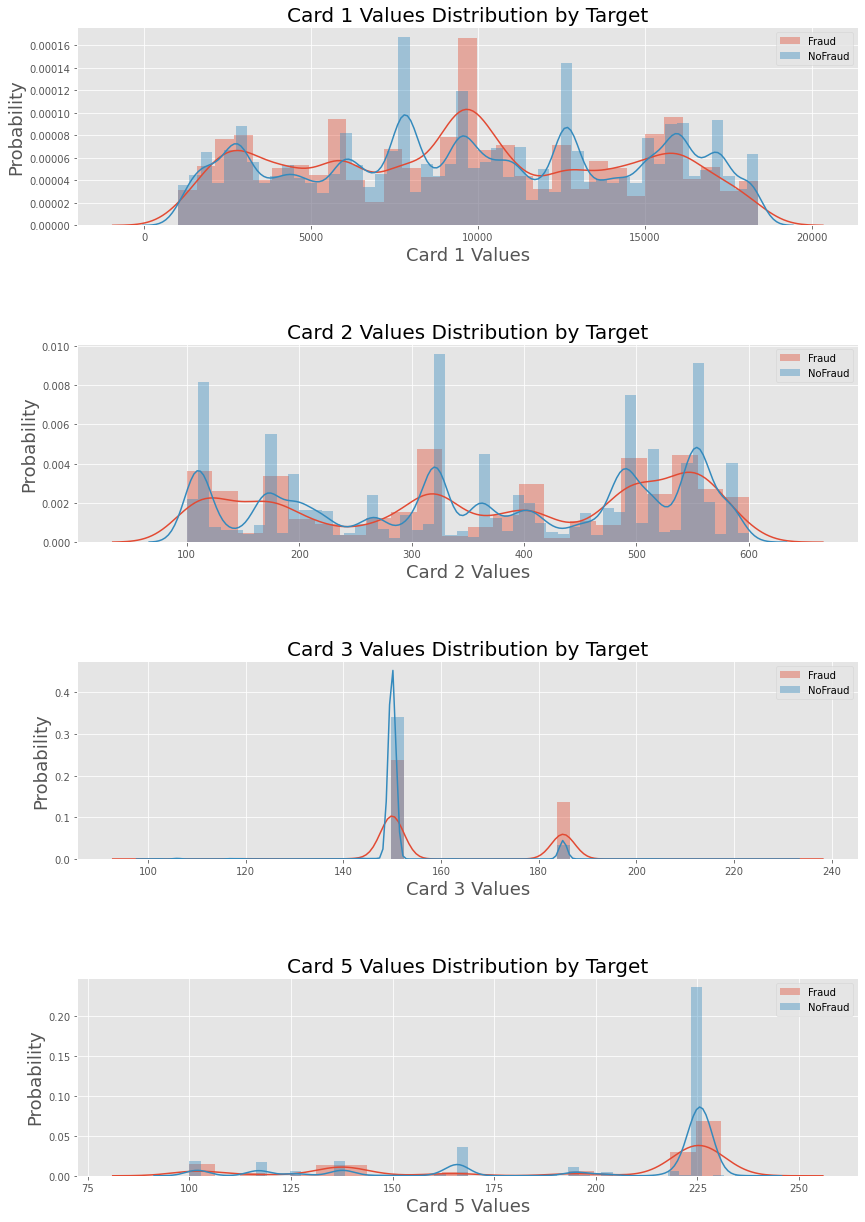

In [188]:
tmp = pd.crosstab(train['card3'], train['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

tmp2 = pd.crosstab(train['card5'], train['isFraud'], normalize='index') * 100
tmp2 = tmp2.reset_index()
tmp2.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,22))

plt.subplot(411)
g = sns.distplot(train[train['isFraud'] == 1]['card1'], label='Fraud',kde=True)
g = sns.distplot(train[train['isFraud'] == 0]['card1'], label='NoFraud',kde=True)
g.legend()
g.set_title("Card 1 Values Distribution by Target", fontsize=20)
g.set_xlabel("Card 1 Values", fontsize=18)
g.set_ylabel("Probability", fontsize=18)

plt.subplot(412)
g1 = sns.distplot(train[train['isFraud'] == 1]['card2'].dropna(), label='Fraud')
g1 = sns.distplot(train[train['isFraud'] == 0]['card2'].dropna(), label='NoFraud')
g1.legend()
g1.set_title("Card 2 Values Distribution by Target", fontsize=20)
g1.set_xlabel("Card 2 Values", fontsize=18)
g1.set_ylabel("Probability", fontsize=18)

plt.subplot(413)
g2 = sns.distplot(train[train['isFraud'] == 1]['card3'].dropna(), label='Fraud')
g2 = sns.distplot(train[train['isFraud'] == 0]['card3'].dropna(), label='NoFraud')
g2.legend()
g2.set_title("Card 3 Values Distribution by Target", fontsize=20)
g2.set_xlabel("Card 3 Values", fontsize=18)
g2.set_ylabel("Probability", fontsize=18)


plt.subplot(414)
g3 = sns.distplot(train[train['isFraud'] == 1]['card5'].dropna(), label='Fraud')
g3 = sns.distplot(train[train['isFraud'] == 0]['card5'].dropna(), label='NoFraud')
g3.legend()
g3.set_title("Card 5 Values Distribution by Target", fontsize=20)
g3.set_xlabel("Card 5 Values", fontsize=18)
g3.set_ylabel("Probability", fontsize=18)

plt.subplots_adjust(hspace = 0.6, top = 0.85)
plt.show()

#### Categorical: Card 4,6

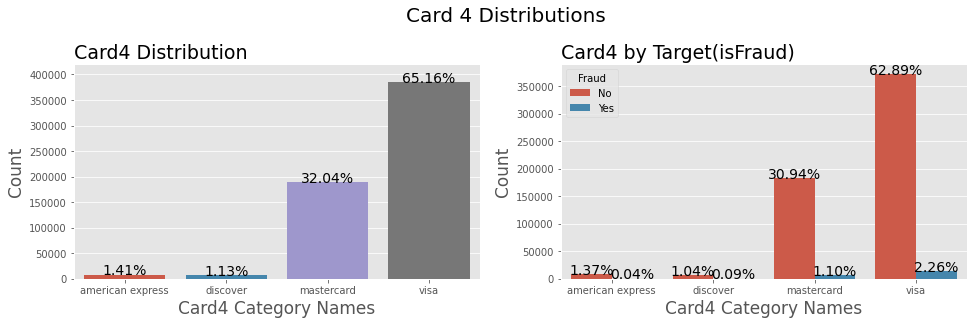

In [186]:
tmp = pd.crosstab(train['card4'], train['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(16,10))
plt.suptitle('Card 4 Distributions', fontsize=20)

plt.subplot(221)
g = sns.countplot(x='card4', data=train)
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])
g.set_title("Card4 Distribution", fontsize=19, loc='left')
g.set_ylim(0,420000)
g.set_xlabel("Card4 Category Names", fontsize=17)
g.set_ylabel("Count", fontsize=17)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=14) 


plt.subplot(222)
g1 = sns.countplot(x='card4', hue='isFraud', data=train)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
g1.set_title("Card4 by Target(isFraud)", fontsize=19, loc='left')
g1.set_xlabel("Card4 Category Names", fontsize=17)
g1.set_ylabel("Count", fontsize=17)

for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=14) 

plt.subplots_adjust(hspace = 0.6, top = 0.9)
plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


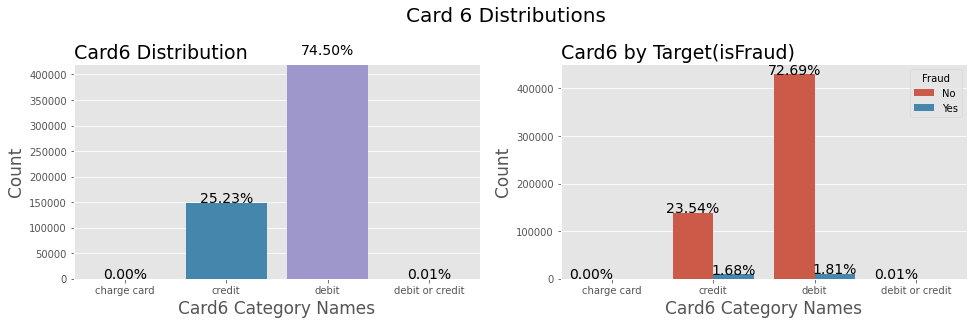

In [187]:
tmp = pd.crosstab(train['card6'], train['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(16,10))
plt.suptitle('Card 6 Distributions', fontsize=20)

plt.subplot(221)
g = sns.countplot(x='card6', data=train)
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])
g.set_title("Card6 Distribution", fontsize=19, loc='left')
g.set_ylim(0,420000)
g.set_xlabel("Card6 Category Names", fontsize=17)
g.set_ylabel("Count", fontsize=17)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=14) 


plt.subplot(222)
g1 = sns.countplot(x='card6', hue='isFraud', data=train)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
g1.set_title("Card6 by Target(isFraud)", fontsize=19, loc='left')
g1.set_xlabel("Card6 Category Names", fontsize=17)
g1.set_ylabel("Count", fontsize=17)

for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=14) 

plt.subplots_adjust(hspace = 0.6, top = 0.9)
plt.show()

### Addr 1-2

In [205]:
print(' addr1 - has {} NA values'.format(train['addr1'].isna().sum()))
print(' addr2 - has {} NA values'.format(train['addr2'].isna().sum()))

 addr1 - has 65706 NA values
 addr2 - has 65706 NA values


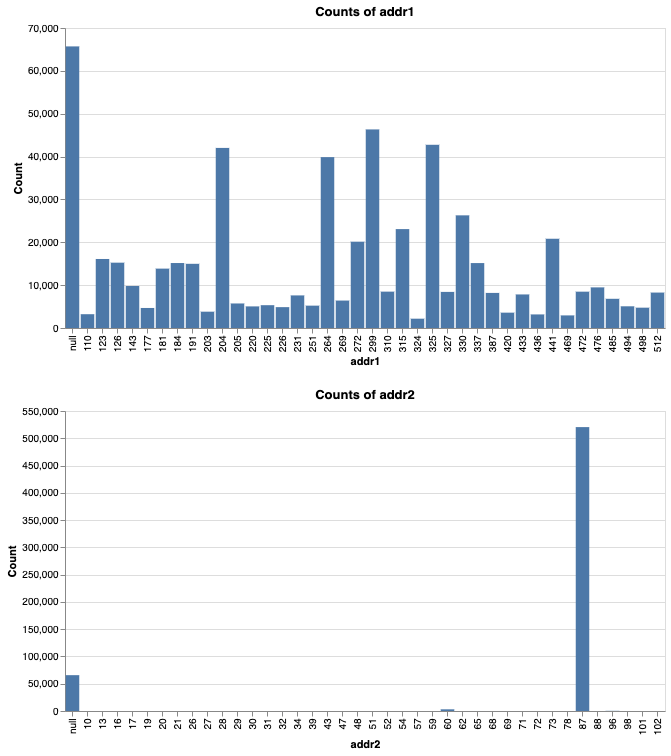

In [209]:
charts = {}
for i in ['addr1', 'addr2']:
    feature_count = train[i].value_counts(dropna=False).reset_index()[:40].rename(columns={i: 'count', 'index': i})
    chart = alt.Chart(feature_count).mark_bar().encode(
                x=alt.X(f"{i}:N", axis=alt.Axis(title=i)),
                y=alt.Y('count:Q', axis=alt.Axis(title='Count')),
                tooltip=[i, 'count']
            ).properties(title=f"Counts of {i}", width=600)
    charts[i] = chart
    
(charts['addr1'] & charts['addr2'])

### Dist 1-2

In [211]:
print(' dist1 - has {} NA values'.format(train['dist1'].isna().sum()))
print(' dist2 - has {} NA values'.format(train['dist2'].isna().sum()))

 dist1 - has 352271 NA values
 dist2 - has 552913 NA values


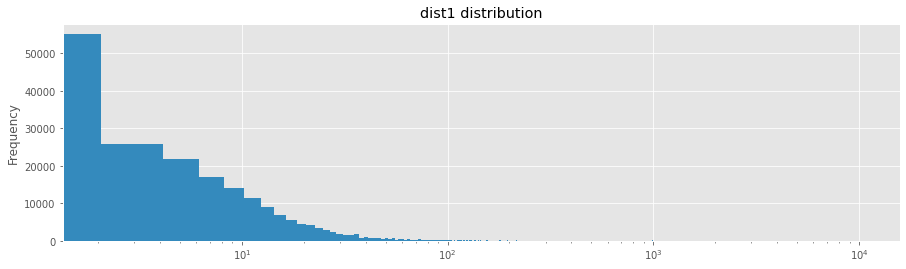

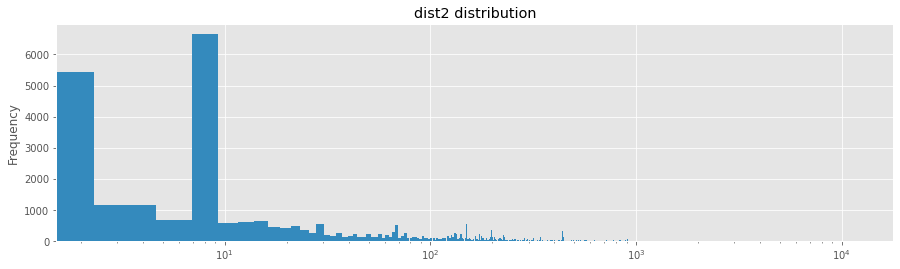

In [207]:
# Plotting with logx to better show the distribution
train['dist1'].plot(kind='hist',
                    bins=5000,
                    figsize=(15, 4),
                    title='dist1 distribution',
                    color=color_pal[1],
                    logx=True)
plt.show()
train['dist2'].plot(kind='hist',
                    bins=5000,
                    figsize=(15, 4),
                    title='dist2 distribution',
                    color=color_pal[1],
                    logx=True)
plt.show()

### Email Domain

In [212]:
print(' P_emaildomain - has {} NA values'.format(train['P_emaildomain'].isna().sum()))
print(' R_emaildomain - has {} NA values'.format(train['R_emaildomain'].isna().sum()))

 P_emaildomain - has 94456 NA values
 R_emaildomain - has 453249 NA values


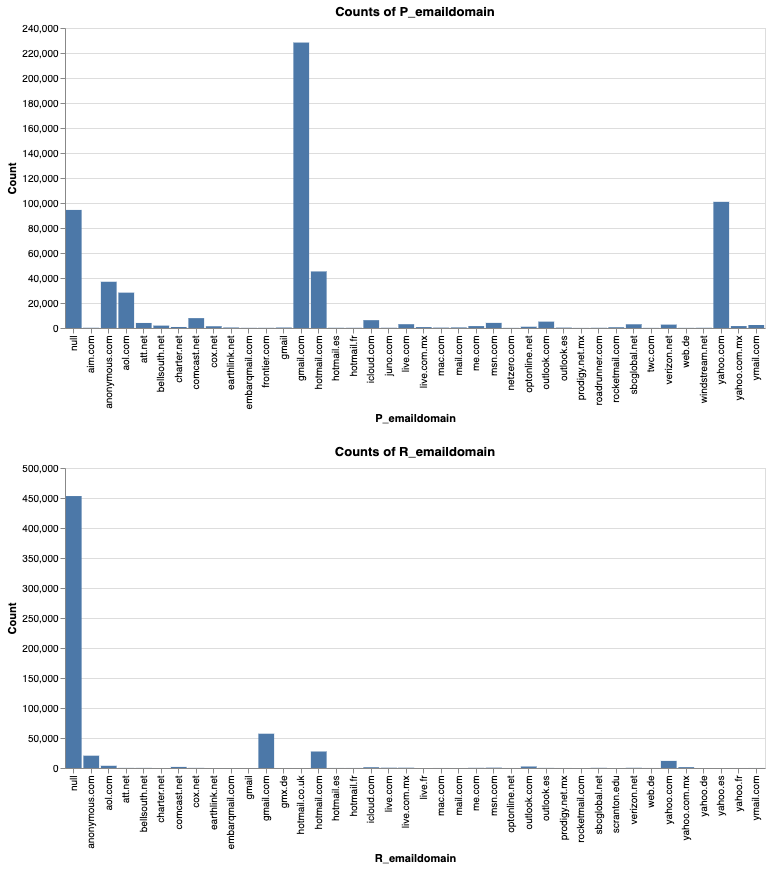

In [214]:
charts = {}
for i in ['P_emaildomain', 'R_emaildomain']:
    feature_count = train[i].value_counts(dropna=False).reset_index()[:40].rename(columns={i: 'count', 'index': i})
    chart = alt.Chart(feature_count).mark_bar().encode(
                x=alt.X(f"{i}:N", axis=alt.Axis(title=i)),
                y=alt.Y('count:Q', axis=alt.Axis(title='Count')),
                tooltip=[i, 'count']
            ).properties(title=f"Counts of {i}", width=700)
    charts[i] = chart
    
(charts['P_emaildomain'] & charts['R_emaildomain'])

### C 1-14

In [42]:
resumetable(train[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
                      'C9', 'C10', 'C11', 'C12', 'C13', 'C14']])

Dataset Shape: (590540, 14)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,C1,float16,0,1495,1.0,1.0,1.0,2.72
1,C2,float16,0,1167,1.0,1.0,1.0,2.75
2,C3,float16,0,27,0.0,0.0,0.0,0.04
3,C4,float16,0,1223,0.0,0.0,0.0,1.12
4,C5,float16,0,319,0.0,0.0,0.0,2.06
5,C6,float16,0,1291,1.0,1.0,1.0,2.52
6,C7,float16,0,1069,0.0,0.0,0.0,0.71
7,C8,float16,0,1130,0.0,0.0,0.0,1.25
8,C9,float16,0,205,1.0,0.0,1.0,2.62
9,C10,float16,0,1122,0.0,0.0,0.0,1.23


<AxesSubplot:>

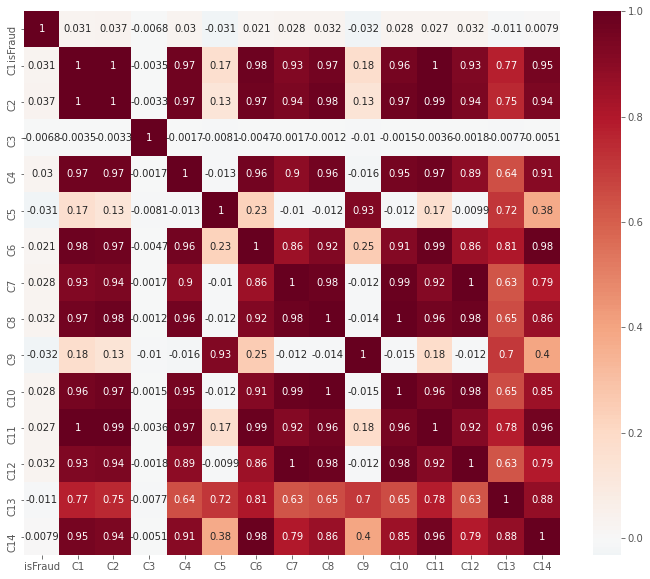

In [86]:
cols = ['isFraud'] + ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
                      'C9', 'C10', 'C11', 'C12', 'C13', 'C14']
plt.figure(figsize=(10,8))
sns.heatmap(train[cols].corr(), cmap='RdBu_r', annot=True, center=0.0)

### D 1-15

In [91]:
resumetable(train[['D1', 'D2', 'D3','D4',  'D5', 'D6', 'D7', 'D8', 'D9','D10','D11','D12','D13','D14','D15']])

Dataset Shape: (590540, 15)


,Name,dtypes,Missing,% populated,Uniques,First Value,Second Value,Third Value,Entropy
0,D1,float64,1269,0.997851,641,14.0,0.0,0.0,5.57
1,D2,float64,280797,0.524508,641,NaN,NaN,NaN,8.57
2,D3,float64,262878,0.554851,649,13.0,NaN,NaN,5.60
3,D4,float64,168922,0.713953,808,NaN,0.0,0.0,6.42
4,D5,float64,309841,0.475326,688,NaN,NaN,NaN,5.95
5,D6,float64,517353,0.123932,829,NaN,NaN,NaN,4.09
6,D7,float64,551623,0.065901,597,NaN,NaN,NaN,4.29
7,D8,float64,515614,0.126877,12353,NaN,NaN,NaN,11.32
8,D9,float64,515614,0.126877,24,NaN,NaN,NaN,4.29
9,D10,float64,76022,0.871267,818,13.0,0.0,0.0,6.09


<AxesSubplot:>

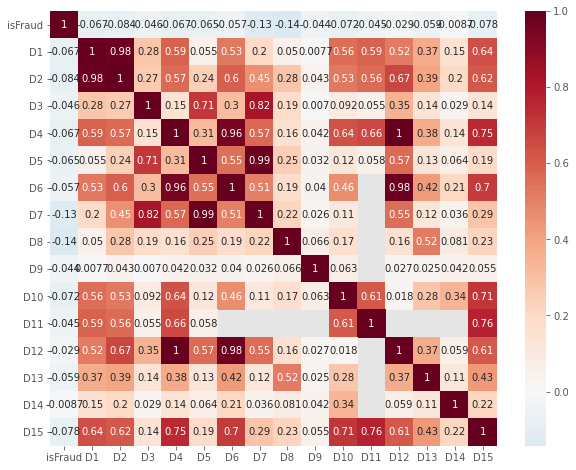

In [92]:
cols = ['isFraud'] + ['D1', 'D2', 'D3','D4',  'D5', 'D6', 'D7', 'D8', 'D9','D10','D11','D12','D13','D14','D15']
plt.figure(figsize=(10,8))
sns.heatmap(train[cols].corr(), cmap='RdBu_r', annot=True, center=0.0)

### M1-9

In [44]:
resumetable(train[['M1', 'M2', 'M3','M4',  'M5', 'M6', 'M7', 'M8', 'M9']])

Dataset Shape: (590540, 9)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,M1,category,271100,2,T,NaN,T,0.00
1,M2,category,271100,2,T,NaN,T,0.49
2,M3,category,271100,2,T,NaN,T,0.75
3,M4,category,281444,3,M2,M0,M0,1.31
4,M5,category,350482,2,F,T,F,0.99
5,M6,category,169360,2,T,T,F,1.00
6,M7,category,346265,2,NaN,NaN,F,0.57
7,M8,category,346252,2,NaN,NaN,F,0.95
8,M9,category,346252,2,NaN,NaN,F,0.63


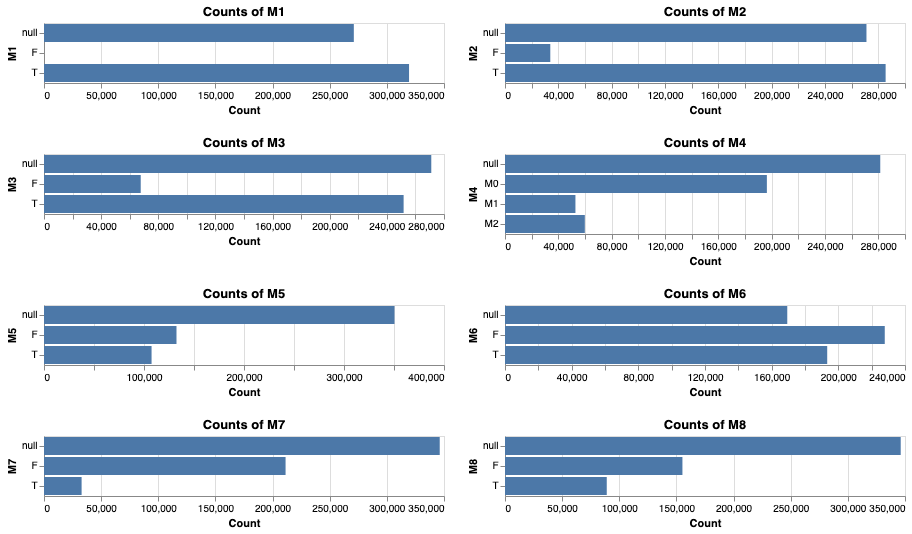

In [216]:
charts = {}
for i in [ 'M1', 'M2', 'M3','M4',  'M5', 'M6', 'M7', 'M8', 'M9']:
    feature_count = train[i].value_counts(dropna=False).reset_index().rename(columns={i: 'count', 'index': i})
    chart = alt.Chart(feature_count).mark_bar().encode(
                y=alt.Y(f"{i}:N", axis=alt.Axis(title=i)),
                x=alt.X('count:Q', axis=alt.Axis(title='Count')),
                tooltip=[i, 'count']
            ).properties(title=f"Counts of {i}", width=400)
    charts[i] = chart                         
    
(charts['M1'] | charts['M2']) & (charts['M3'] | charts['M4']) & (charts['M5'] | charts['M6']) & (charts['M7'] | charts['M8'])

### V 1-339

In [74]:
v_cols = [c for c in train if c[0] == 'V']
train['v_mean'] = train[v_cols].mean(axis=1)

In [75]:
resumetable(train[v_cols])

Dataset Shape: (590540, 339)


,Name,dtypes,Missing,% populated,Uniques,First Value,Second Value,Third Value,Entropy
0,V1,float16,279287,0.527065,2,1.0,NaN,1.0,0.00
1,V2,float16,279287,0.527065,9,1.0,NaN,1.0,0.27
2,V3,float16,279287,0.527065,10,1.0,NaN,1.0,0.40
3,V4,float16,279287,0.527065,7,1.0,NaN,1.0,0.86
4,V5,float16,279287,0.527065,7,1.0,NaN,1.0,0.95
...,...,...,...,...,...,...,...,...,...
334,V335,float16,508189,0.139450,669,NaN,NaN,NaN,1.27
335,V336,float16,508189,0.139450,355,NaN,NaN,NaN,0.93
336,V337,float32,508189,0.139450,254,NaN,NaN,NaN,1.03
337,V338,float32,508189,0.139450,380,NaN,NaN,NaN,1.19


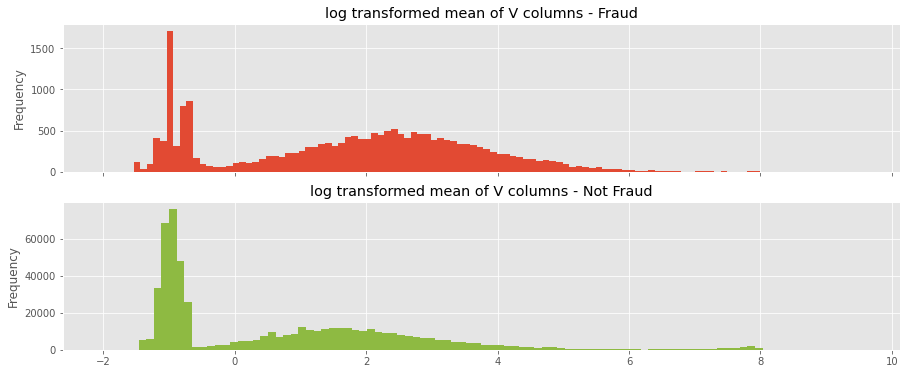

In [231]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 6))
train.loc[train['isFraud'] == 1]['v_mean'] \
    .apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='log transformed mean of V columns - Fraud',
          ax=ax1)
train.loc[train['isFraud'] == 0]['v_mean'] \
    .apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='log transformed mean of V columns - Not Fraud',
          color=color_pal[5],
          ax=ax2)
plt.show()

### Identity: ID+Device

#### Numerical

In [58]:
resumetable(train[['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18',
       'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25',
       'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32',
       'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']])

Dataset Shape: (590540, 27)


,Name,dtypes,Missing,% populated,Uniques,First Value,Second Value,Third Value,Entropy
0,id_12,category,446307,0.244239,2,NaN,NaN,NaN,0.60
1,id_13,float16,463220,0.215599,54,NaN,NaN,NaN,2.57
2,id_14,float16,510496,0.135544,25,NaN,NaN,NaN,1.80
3,id_15,category,449555,0.238739,3,NaN,NaN,NaN,1.33
4,id_16,category,461200,0.219020,2,NaN,NaN,NaN,1.00
5,id_17,float16,451171,0.236003,104,NaN,NaN,NaN,1.27
6,id_18,float16,545427,0.076393,18,NaN,NaN,NaN,1.57
7,id_19,float16,451222,0.235916,522,NaN,NaN,NaN,5.42
8,id_20,float16,451279,0.235820,394,NaN,NaN,NaN,5.32
9,id_21,float16,585381,0.008736,490,NaN,NaN,NaN,4.63


In [226]:
train[['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18',
       'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25',
       'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32',
       'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']].describe(include='all')

,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,...,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38
count,144233,127320.0,80044.0,140985,129340,139369.0,4.511300e+04,139318.0,139261.0,5159.0,...,140978,77565,140282,77586.0,73289,77805,140985,140985,140985,140985
unique,2,NaN,NaN,3,2,NaN,NaN,NaN,NaN,NaN,...,2,75,130,NaN,260,4,2,2,2,2
top,NotFound,NaN,NaN,Found,Found,NaN,NaN,NaN,NaN,NaN,...,Found,Windows 10,chrome 63.0,NaN,1920x1080,match_status:2,T,F,T,F
freq,123025,NaN,NaN,67728,66324,NaN,NaN,NaN,NaN,NaN,...,74926,21155,22000,NaN,16874,60011,77814,134066,110452,73922
mean,NaN,NaN,NaN,NaN,NaN,NaN,inf,NaN,NaN,inf,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,0.0,NaN,NaN,NaN,0.0,1.561523e+00,NaN,NaN,inf,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,10.0,-660.0,NaN,NaN,100.0,1.000000e+01,100.0,100.0,100.0,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,49.0,-360.0,NaN,NaN,166.0,1.300000e+01,266.0,256.0,252.0,...,NaN,NaN,NaN,24.0,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,52.0,-300.0,NaN,NaN,166.0,1.500000e+01,341.0,472.0,252.0,...,NaN,NaN,NaN,24.0,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,52.0,-300.0,NaN,NaN,225.0,1.500000e+01,427.0,533.0,486.5,...,NaN,NaN,NaN,32.0,NaN,NaN,NaN,NaN,NaN,NaN


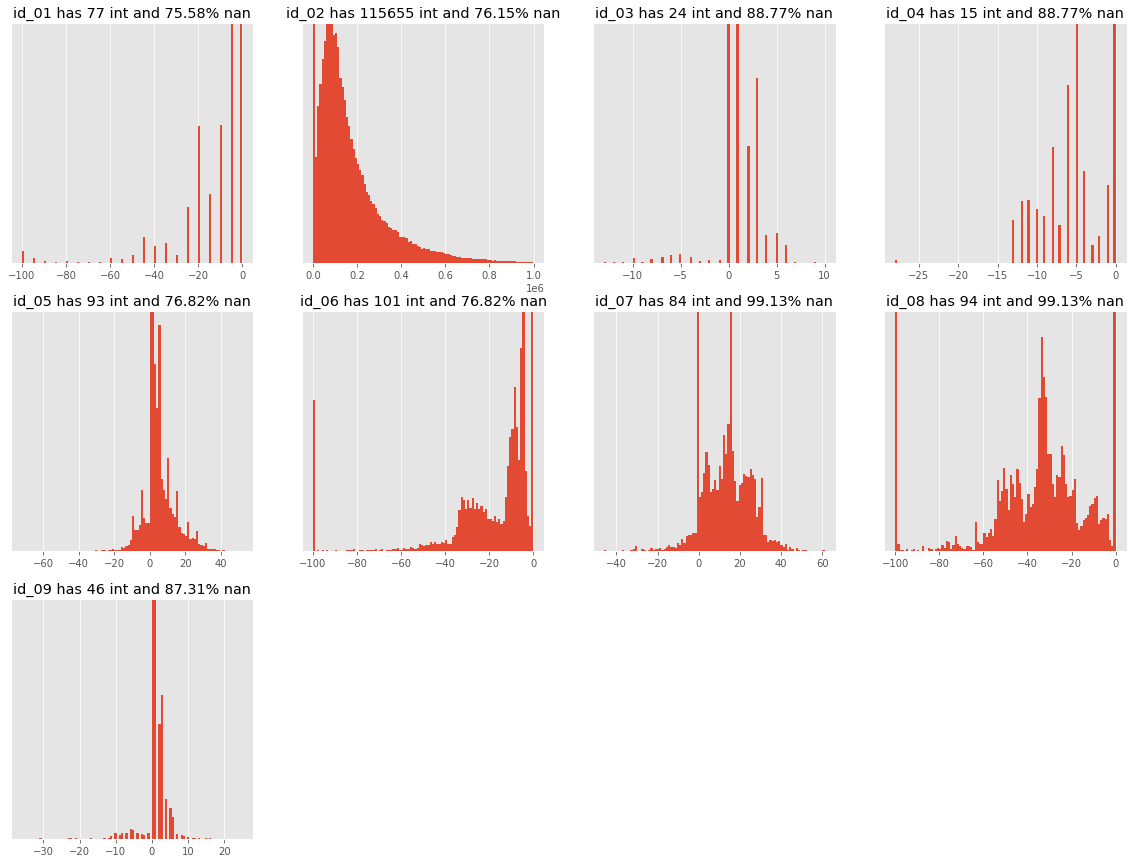

In [124]:
ids = ['id_0'+str(x) for x in range(1,10)]
cats = ['id_23','id_30','id_31','id_33','id_34']
def make_plots2(Vs):
    col = 4
    row = len(Vs)//4+1
    plt.figure(figsize=(20,row*5))
    for i,v in enumerate(Vs):
        plt.subplot(row,col,i+1)
        idx = train[~train[v].isna()].index
        n = train[v].nunique()
        x = np.sum(train.loc[idx,v]!=train.loc[idx,v].astype(int))
        y = np.round(100*np.sum(train[v].isna())/len(train),2)
        t = 'int'
        if x!=0: t = 'float'
        plt.title(v+' has '+str(n)+' '+t+' and '+str(y)+'% nan')
        plt.yticks([])
        h = plt.hist(train.loc[idx,v],bins=100)
        if len(h[0])>1: plt.ylim((0,np.sort(h[0])[-2]))
    plt.show()
    
make_plots2([x for x in ids if x not in cats])

#### Categorical

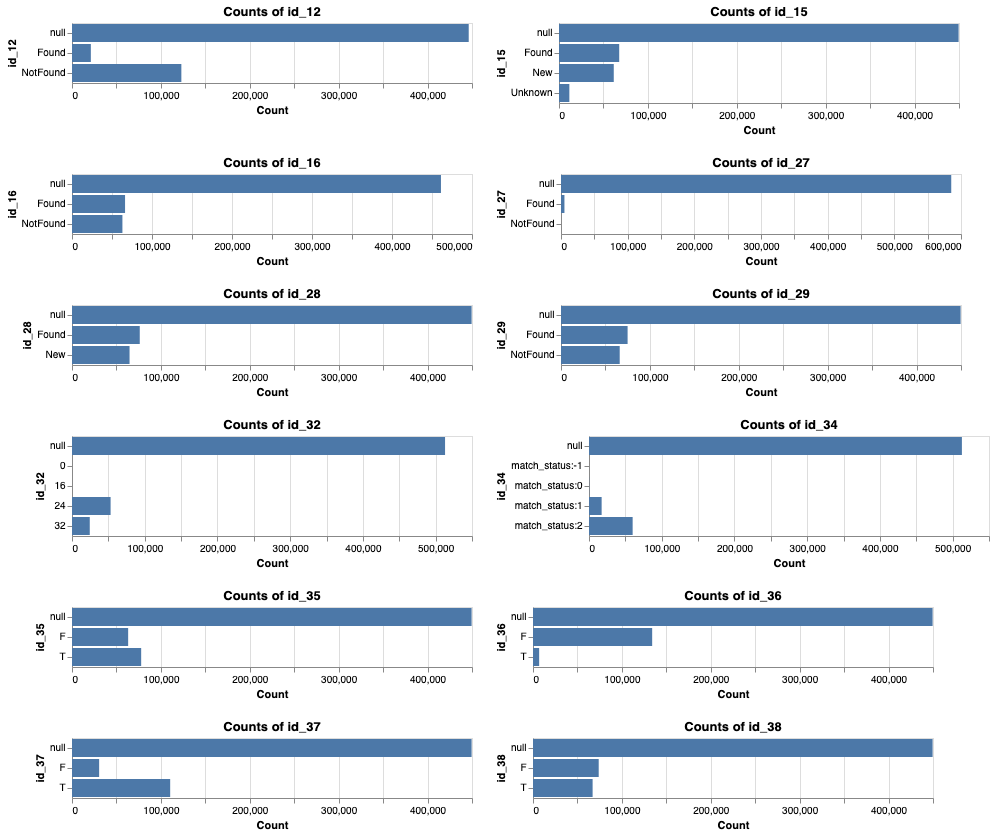

In [204]:
charts = {}
for i in ['id_12', 'id_15', 'id_16', 'id_27','id_28', 'id_29', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']:
    feature_count = train[i].value_counts(dropna=False).reset_index().rename(columns={i: 'count', 'index': i})
    chart=alt.Chart(feature_count).mark_bar().encode(
                y=alt.Y(f"{i}:N", axis=alt.Axis(title=i)),
                x=alt.X('count:Q', axis=alt.Axis(title='Count')),
                tooltip=[i, 'count']).properties(title=f"Counts of {i}", width=400)
    charts[i]=chart
    
# alt.vconcat(*charts)
(charts['id_12'] | charts['id_15'] )&(charts['id_16'] | charts['id_27']) &(charts['id_28'] | charts['id_29']) & (charts['id_32'] | charts['id_34']) &(charts['id_35'] | charts['id_36'])& (charts['id_37']|charts['id_38'])

In [70]:
def wrtTarget(col):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    plt.figure(figsize=(8,3))    
    g3 = sns.boxenplot(x=col, y='TransactionAmt', hue='isFraud', 
                       data=df[df['TransactionAmt'] <= 1104], order=tmp[col].values )
    g3.set_title("Transaction Amount Distribuition by Categories and Target", fontsize=20)
    g3.set_xlabel("Categories", fontsize=17)
    g3.set_ylabel("Transaction Values", fontsize=17)
    plt.show()

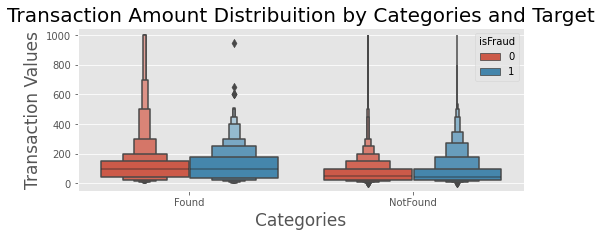

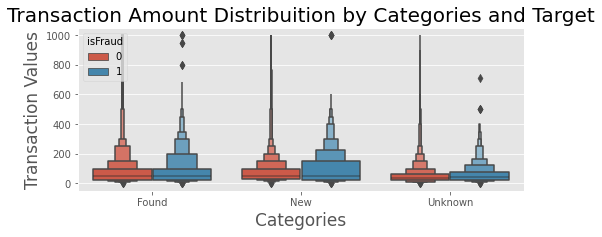

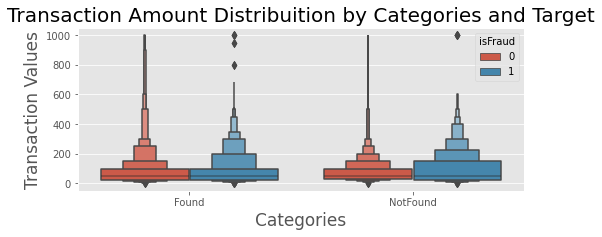

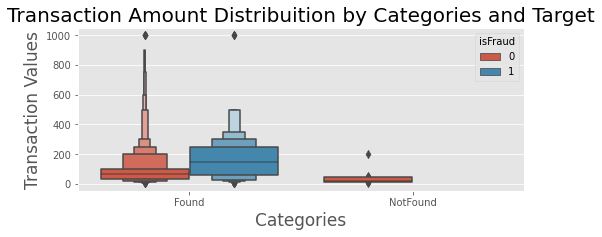

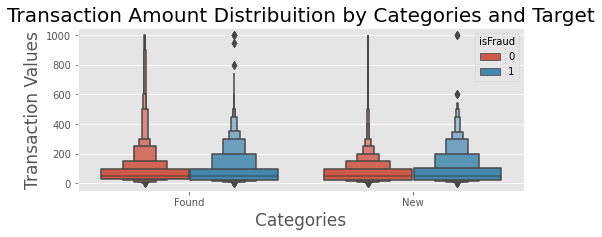

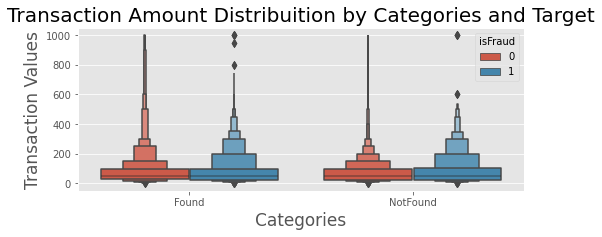

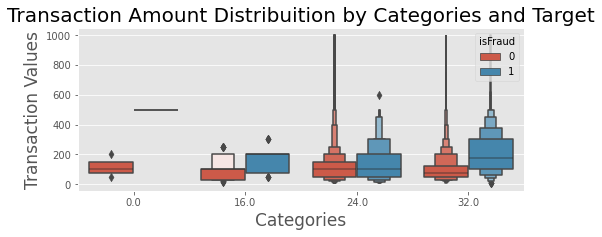

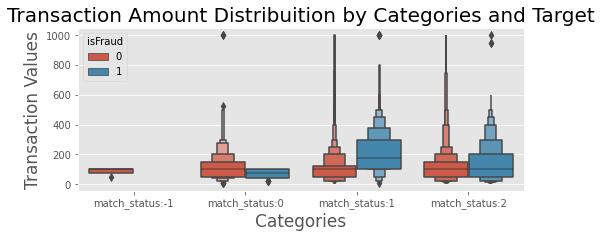

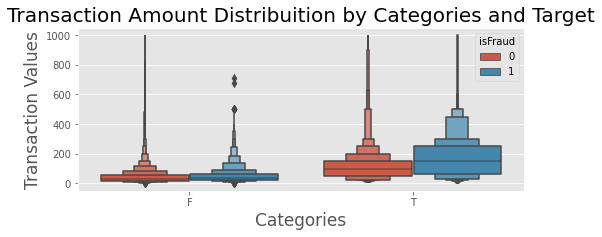

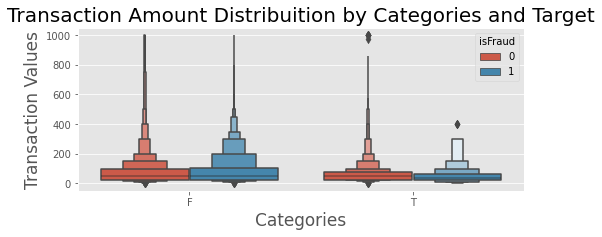

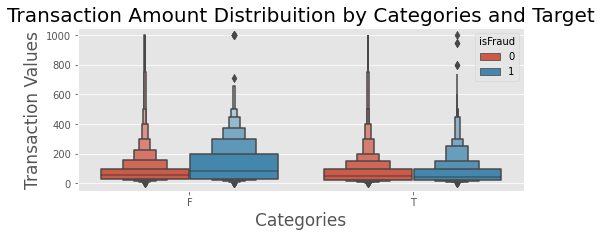

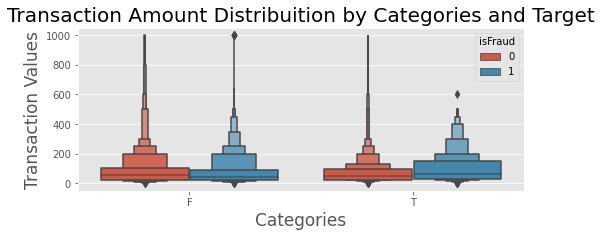

In [125]:
for col in ['id_12', 'id_15', 'id_16', 'id_27','id_28', 'id_29', 'id_32', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']:
    wrtTarget(col)

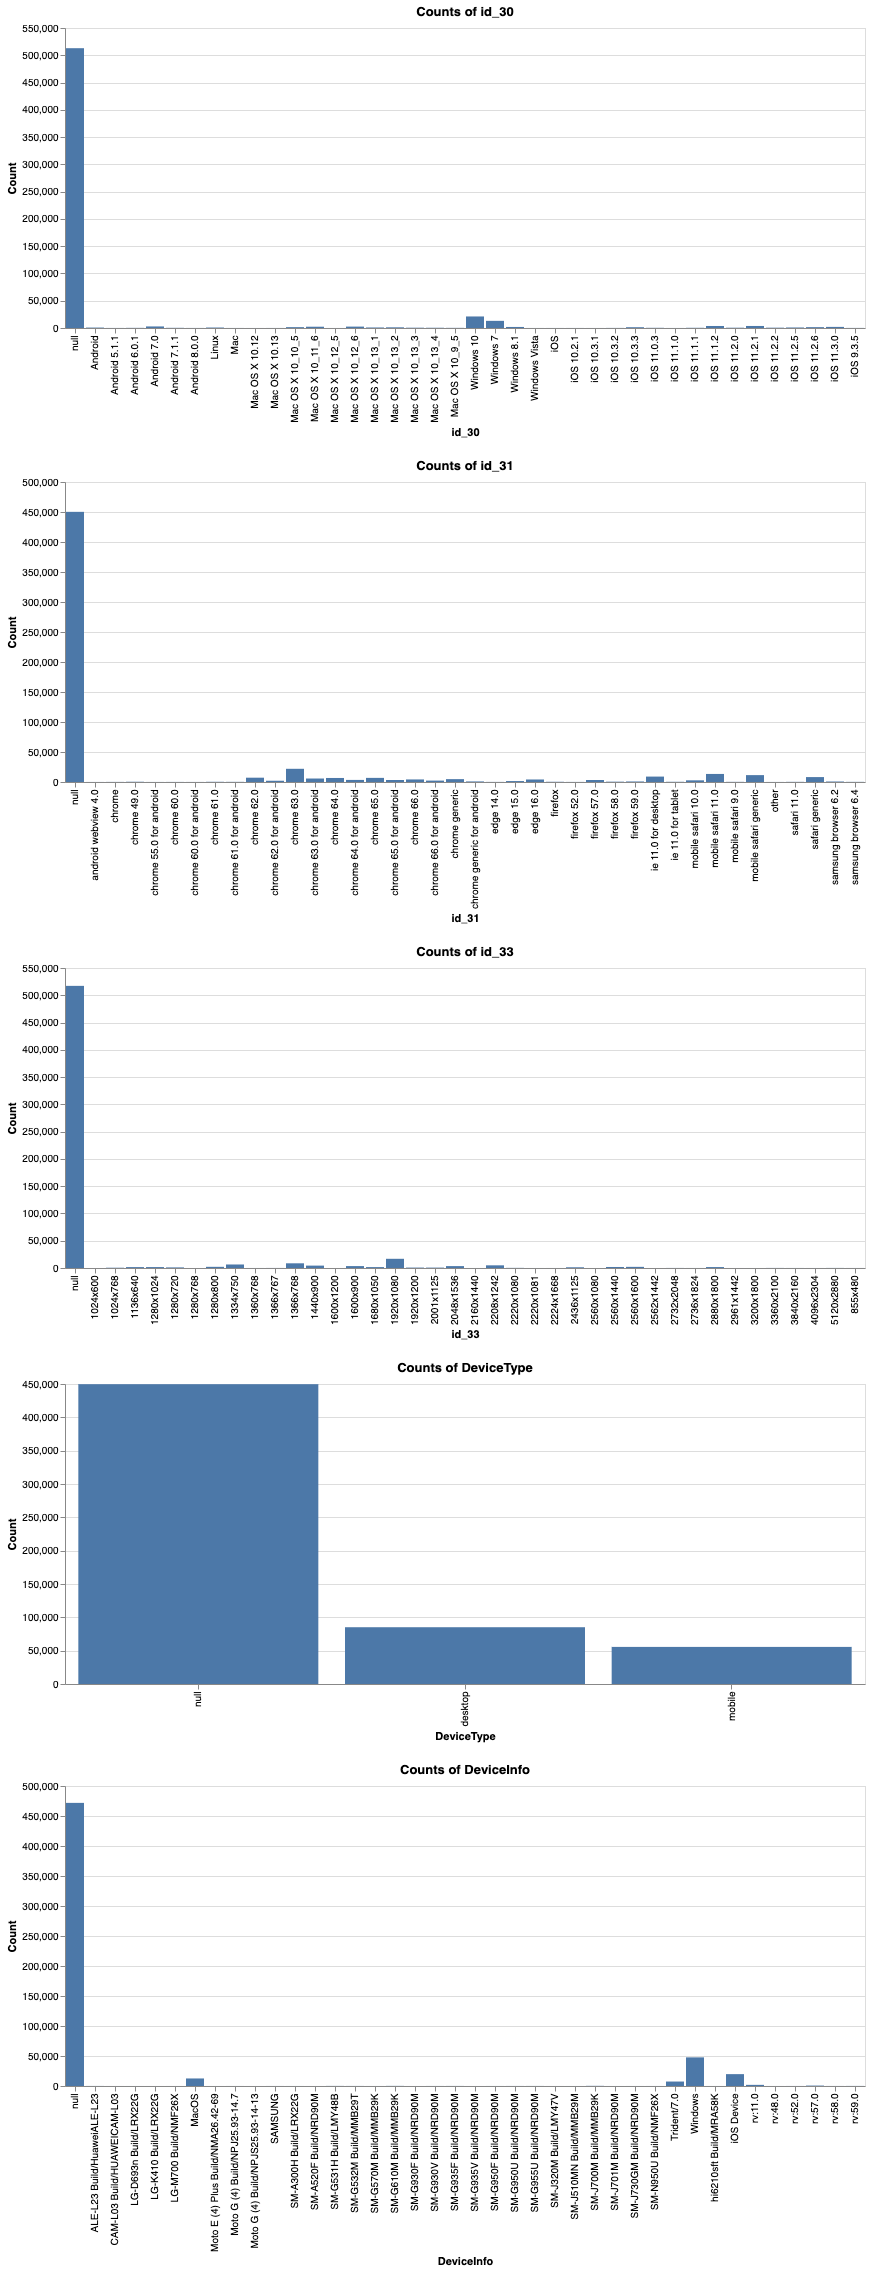

In [147]:
charts = {}
for i in ['id_30', 'id_31', 'id_33', 'DeviceType', 'DeviceInfo']:
    feature_count = train[i].value_counts(dropna=False)[:40].reset_index().rename(columns={i: 'count', 'index': i})
    chart = alt.Chart(feature_count).mark_bar().encode(
                x=alt.X(f"{i}:N", axis=alt.Axis(title=i)),
                y=alt.Y('count:Q', axis=alt.Axis(title='Count')),
                tooltip=[i, 'count']
            ).properties(title=f"Counts of {i}", width=800)
    charts[i] = chart
    
charts['id_30'] & charts['id_31'] & charts['id_33'] & charts['DeviceType'] & charts['DeviceInfo']

## [Feature Selection and Engineering - Zining Han](#6)<a id="6"></a> <br>

There are some biased records having more than 95% same value, so we consider them to be out of this data set. Columns with too much NAs will also be dropped out.

In [78]:
train=train.drop(columns='v_mean')

<AxesSubplot:>

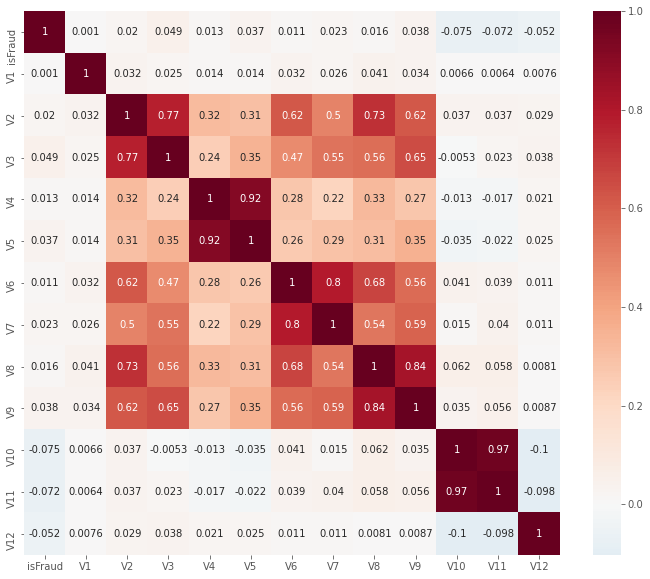

In [120]:
v_cols = [c for c in train if c[0] == 'V'][:12]
cols = ['isFraud'] + v_cols
plt.figure(figsize=(12,10))
sns.heatmap(train[cols].corr(), cmap='RdBu_r', annot=True, center=0.0)

In [93]:
grps = [[1],[2,3],[4,5],[6,7],[8,9],[10,11]]
def reduce_group(grps,c='V'):
    use = []
    for g in grps:
        mx = 0; vx = g[0]
        for gg in g:
            n = train[c+str(gg)].nunique()
            if n>mx:
                mx = n
                vx = gg
            #print(str(gg)+'-'+str(n),', ',end='')
        use.append(vx)
        #print()
    print('Use these',use)
reduce_group(grps)

Use these [1, 3, 4, 6, 8, 11]


In [126]:
# By using similar method for all V-variables, we get
v =  [1, 3, 4, 6, 8, 11]
v += [13, 14, 17, 20, 23, 26, 27, 30]
v += [36, 37, 40, 41, 44, 47, 48]
v += [54, 56, 59, 62, 65, 67, 68, 70]
v += [76, 78, 80, 82, 86, 88, 89, 91]
v += [96, 98, 99, 104]
v += [107, 108, 111, 115, 117, 120, 121, 123]
v += [124, 127, 129, 130, 136]
v += [138, 139, 142, 147, 156, 162]
v += [165, 160, 166]
v += [178, 176, 173, 182]
v += [187, 203, 205, 207, 215]
v += [169, 171, 175, 180, 185, 188, 198, 210, 209]
v += [218, 223, 224, 226, 228, 229, 235]
v += [240, 258, 257, 253, 252, 260, 261]
v += [264, 266, 267, 274, 277]
v += [220, 221, 234, 238, 250, 271]
v += [294, 284, 285, 286, 291, 297]
v += [303, 305, 307, 309, 310, 320]
v += [281, 283, 289, 296, 301, 314]
v += [332, 325, 335, 338]

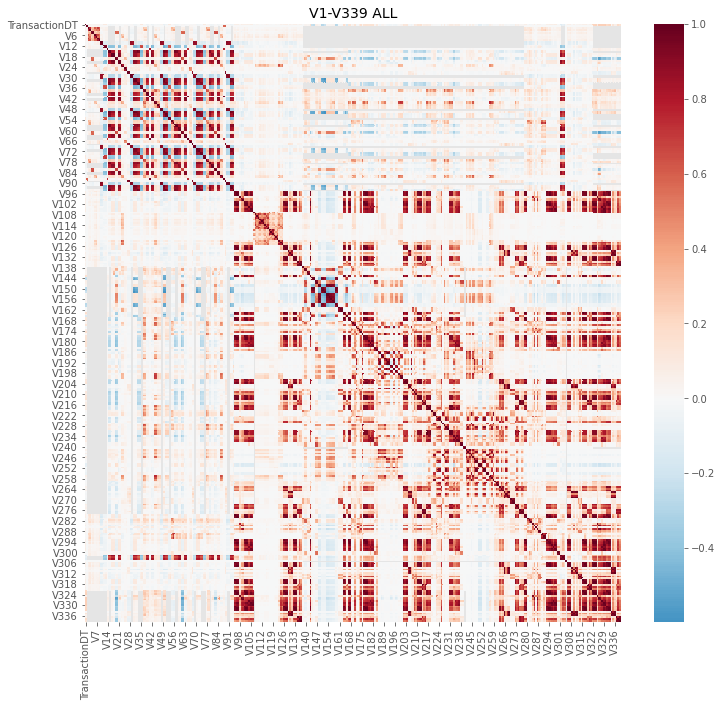

In [129]:
cols = ['TransactionDT'] + ['V'+str(x) for x in range(1,340)]
train2 = train[cols].sample(frac=0.2)
plt.figure(figsize=(12,11))
sns.heatmap(train2[cols].corr(), cmap='RdBu_r', annot=False, center=0.0)
plt.title('V1-V339 ALL',fontsize=14)
plt.show()

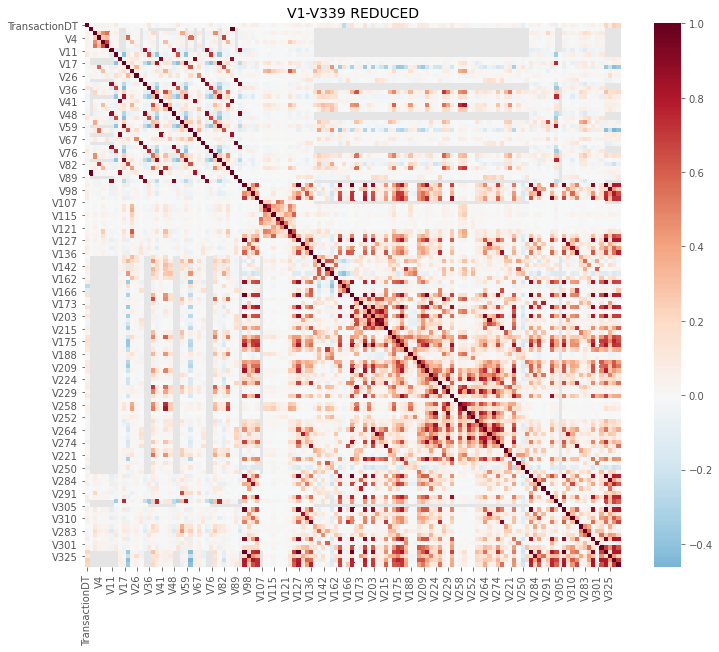

In [128]:
# Comparing the two graphs, we can see that basically no information was lost
cols = ['TransactionDT'] + ['V'+str(x) for x in v]
train2 = train[cols].sample(frac=0.2)
plt.figure(figsize=(12,10))
sns.heatmap(train2[cols].corr(), cmap='RdBu_r', annot=False, center=0.0)
plt.title('V1-V339 REDUCED',fontsize=14)
plt.show()

In [130]:
res=[]
for col in train.columns:
    na = train[col].isna().sum()/len(train[col])
    rate = train[col].value_counts(normalize=True, dropna=False).values[0]
    if rate > 0.98 or na > 0.98:
        train.drop(columns=col,inplace=True)
        res.append(col)
print(res)

['C3', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V305', 'id_07', 'id_08', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27']


Let's create some aggregations. There is no logic in them - simply aggregations on top features.

In [131]:
# New feature - log of transaction amount.
train['TransactionAmt_Log'] = np.log(train['TransactionAmt'])
# test['TransactionAmt_Log'] = np.log(test['TransactionAmt'])

# New feature - day of week in which a transaction happened.
train['Transaction_day_of_week'] = np.floor((train['TransactionDT'] / (3600 * 24) - 1) % 7)
# test['Transaction_day_of_week'] = np.floor((test['TransactionDT'] / (3600 * 24) - 1) % 7)

In [132]:
train['TransactionAmt_to_mean_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_mean_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_std_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('std')
train['TransactionAmt_to_std_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('std')

# test['TransactionAmt_to_mean_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('mean')
# test['TransactionAmt_to_mean_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('mean')
# test['TransactionAmt_to_std_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('std')
# test['TransactionAmt_to_std_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('std')

train['id_02_to_mean_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('mean')
train['id_02_to_mean_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('mean')
train['id_02_to_std_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('std')
train['id_02_to_std_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('std')

# test['id_02_to_mean_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('mean')
# test['id_02_to_mean_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('mean')
# test['id_02_to_std_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('std')
# test['id_02_to_std_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('std')

train['D15_to_mean_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('mean')
train['D15_to_mean_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('mean')
train['D15_to_std_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('std')
train['D15_to_std_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('std')

# test['D15_to_mean_card1'] = test['D15'] / test.groupby(['card1'])['D15'].transform('mean')
# test['D15_to_mean_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('mean')
# test['D15_to_std_card1'] = test['D15'] / test.groupby(['card1'])['D15'].transform('std')
# test['D15_to_std_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('std')

train['D15_to_mean_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('mean')
train['D15_to_mean_addr2'] = train['D15'] / train.groupby(['addr2'])['D15'].transform('mean')
train['D15_to_std_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('std')
train['D15_to_std_addr2'] = train['D15'] / train.groupby(['addr2'])['D15'].transform('std')

# test['D15_to_mean_addr1'] = test['D15'] / test.groupby(['addr1'])['D15'].transform('mean')
# test['D15_to_mean_addr2'] = test['D15'] / test.groupby(['addr2'])['D15'].transform('mean')
# test['D15_to_std_addr1'] = test['D15'] / test.groupby(['addr1'])['D15'].transform('std')
# test['D15_to_std_addr2'] = test['D15'] / test.groupby(['addr2'])['D15'].transform('std')

In [133]:
train[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = train['P_emaildomain'].str.split('.', expand=True)
train[['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']] = train['R_emaildomain'].str.split('.', expand=True)
# test[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = test['P_emaildomain'].str.split('.', expand=True)
# test[['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']] = test['R_emaildomain'].str.split('.', expand=True)

In [134]:
train.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,D15_to_mean_addr1,D15_to_mean_addr2,D15_to_std_addr1,D15_to_std_addr2,P_emaildomain_1,P_emaildomain_2,P_emaildomain_3,R_emaildomain_1,R_emaildomain_2,R_emaildomain_3
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,0.000000,0.000000,0.000000,0.000000,gmail,com,None,NaN,NaN,NaN
2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,1.611525,1.721392,1.486472,1.522249,outlook,com,None,NaN,NaN,NaN
2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,0.686169,0.606586,0.576638,0.536412,yahoo,com,None,NaN,NaN,NaN
2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,gmail,com,None,NaN,NaN,NaN


## [Resampling](#7)<a id="7"></a> <br>

A widely adopted technique for dealing with highly unbalanced datasets is called resampling. It consists of removing samples from the majority class (under-sampling) and / or adding more examples from the minority class (over-sampling).

![](https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/resampling.png)

## [Resampling Techniques using sklearn](#8)<a id="8"></a> <br>

<div align='left'><font size='4' color=' #6c3483'> 1.Oversample minority class </font></div>


Oversampling can be defined as adding more copies of the minority class. Oversampling can be a good choice when you don’t have a ton of data to work with.

We will use the resampling module from Scikit-Learn to randomly replicate samples from the minority class.

In [14]:
X=pd.concat([X_train,y_train],axis=1)

not_fraud=X[X.isFraud==0]
fraud=X[X.isFraud==1]

# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled.isFraud.value_counts()

1    455903
0    455903
Name: isFraud, dtype: int64

Text(0, 0.5, 'count')

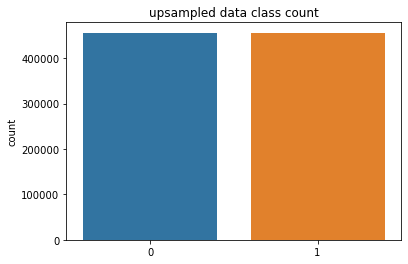

In [15]:
y=upsampled.isFraud.value_counts()
sns.barplot(y=y,x=[0,1])
plt.title('upsampled data class count')
plt.ylabel('count')

<div align='left'><font size='4' color=' #6c3483'>  2. Undersample majority class </font></div>


Undersampling can be defined as removing some observations of the majority class. Undersampling can be a good choice when you have a ton of data -think millions of rows. But a drawback is that we are removing information that may be valuable. This could lead to underfitting and poor generalization to the test set.

We will again use the resampling module from Scikit-Learn to randomly remove samples from the majority class.

In [16]:
not_fraud_downsampled = resample(not_fraud,
                                replace = False, # sample without replacement
                                n_samples = len(fraud), # match minority n
                                random_state = 27) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([not_fraud_downsampled, fraud])

# checking counts
downsampled.isFraud.value_counts()

1    16529
0    16529
Name: isFraud, dtype: int64

Text(0, 0.5, 'count')

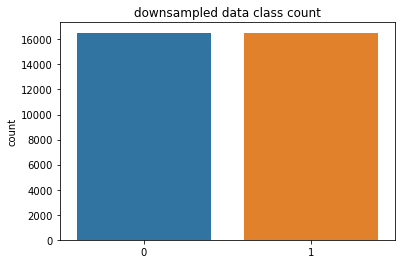

In [17]:
y=downsampled.isFraud.value_counts()
sns.barplot(y=y,x=[0,1])
plt.title('downsampled data class count')
plt.ylabel('count')

We will review other resampling techniques.



For ease of visualization, let's create a small unbalanced sample dataset using the make_classification method:


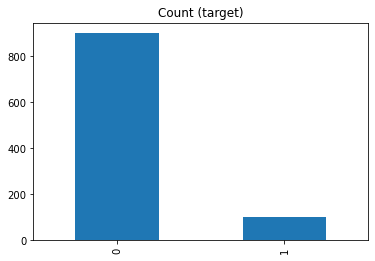

In [18]:
from sklearn.datasets import make_classification

X, y = make_classification(
    n_classes=2, class_sep=1.5, weights=[0.9, 0.1],
    n_informative=3, n_redundant=1, flip_y=0,
    n_features=20, n_clusters_per_class=1,
    n_samples=1000, random_state=10
)

df = pd.DataFrame(X)
df['target'] = y
df.target.value_counts().plot(kind='bar', title='Count (target)')

- We will do an experiment with this data without any resampling technique.
- We will fit and predict the data on a Logistic regression model and observe the output scores.

In [19]:
def logistic(X,y):
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.2,random_state=1)
    lr=LogisticRegression()
    lr.fit(X_train,y_train)
    prob=lr.predict_proba(X_test)
    return (prob[:,1],y_test)

In [20]:
probs,y_test=logistic(X,y)

- We will define two functions to plot precision_recall curve and roc curve

In [21]:
def plot_pre_curve(y_test,probs):
    precision, recall, thresholds = precision_recall_curve(y_test, probs)
    plt.plot([0, 1], [0.5, 0.5], linestyle='--')
    # plot the precision-recall curve for the model
    plt.plot(recall, precision, marker='.')
    plt.title("precision recall curve")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the plot
    plt.show()
    
def plot_roc(y_test,prob):
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title("ROC curve")
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    # show the plot
    plt.show()

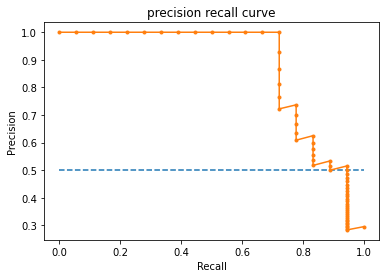

In [22]:
plot_pre_curve(y_test,probs)

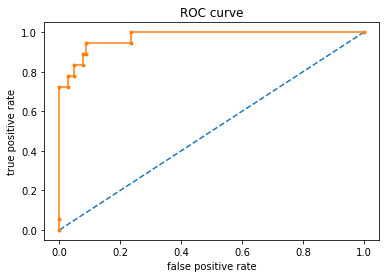

In [23]:
plot_roc(y_test,probs)



We will also create a 2-dimensional plot function, plot_2d_space, to see the data distribution:


In [24]:
def plot_2d_space(X_train, y_train,X=X,y=y ,label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    
    fig,(ax1,ax2)=plt.subplots(1,2, figsize=(8,4))
   
    for l, c, m in zip(np.unique(y), colors, markers):
        ax1.scatter(
            X_train[y_train==l, 0],
            X_train[y_train==l, 1],
            c=c, label=l, marker=m
        )
    for l, c, m in zip(np.unique(y), colors, markers):
        ax2.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
   
    ax1.set_title(label)
    ax2.set_title('original data')
    plt.legend(loc='upper right')
    plt.show()

## [Dimensionality Reduction and Clustering](#9)<a id="9"></a> <br>

Understanding t-SNE:
In order to understand this algorithm you have to understand the following terms:

    Euclidean Distance
    Conditional Probability
    Normal and T-Distribution Plots



In the below section we will implement three major dimensionality reduction algorithms
- **T-sne**
- **PCA**
- **Truncated SVD**

In [25]:
# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 6.4 s
PCA took 0.62 s
Truncated SVD took 0.098 s


Now we will visualize the output of the above three algorithms in a 2D space.

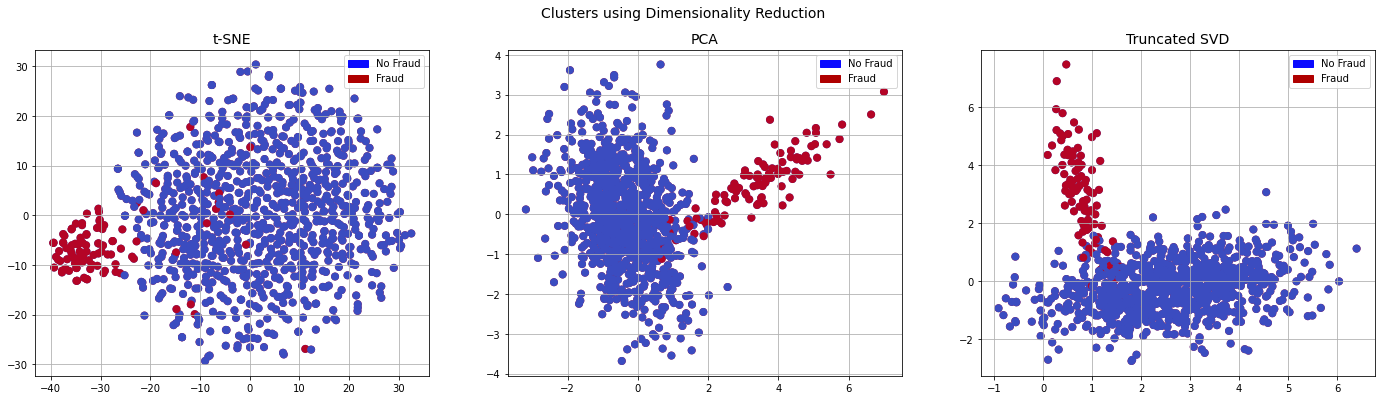

In [26]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)

blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')

# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])

# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

## [Python imbalanced-learn module](#10)<a id='10'></a></br>

A number of more sophisticated resapling techniques have been proposed in the scientific literature.

For example, we can cluster the records of the majority class, and do the under-sampling by removing records from each cluster, thus seeking to preserve information. In over-sampling, instead of creating exact copies of the minority class records, we can introduce small variations into those copies, creating more diverse synthetic samples.

Let's apply some of these resampling techniques, using the Python library imbalanced-learn. It is compatible with scikit-learn and is part of scikit-learn-contrib projects.


<div align='left'><font size='4' color=' #6c3483'>  Random under-sampling  with imbalanced-learn </font></div>



In [28]:
from imblearn.under_sampling import RandomUnderSampler

ran=RandomUnderSampler() ##intialize to return indices of dropped rows
ran=RandomUnderSampler(return_indices=True) ##intialize to return indices of dropped rows
X_rs,y_rs,dropped = ran.fit_sample(X,y)

print("The number of removed indices are ",len(dropped))
plot_2d_space(X_rs,y_rs,X,y,'Random under sampling')

- Let's try fit and predict on this data and observe the outcome.

In [29]:
probs,y_test=logistic(X_rs,y_rs)
plot_pre_curve(y_test,probs)

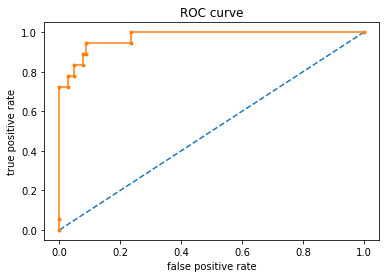

In [30]:
plot_roc(y_test,probs)

<div align='left'><font size='4' color=' #6c3483'>  Random over-sampling  with imbalanced-learn </font></div>



The new data contains 1800 rows 


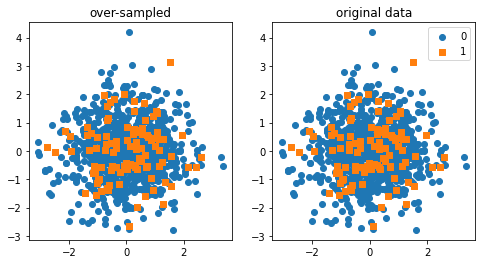

In [31]:
from imblearn.over_sampling import RandomOverSampler

ran=RandomOverSampler()
X_ran,y_ran= ran.fit_resample(X,y)

print('The new data contains {} rows '.format(X_ran.shape[0]))

plot_2d_space(X_ran,y_ran,X,y,'over-sampled')


Let's try fit and predict on this data and observe the outcome.

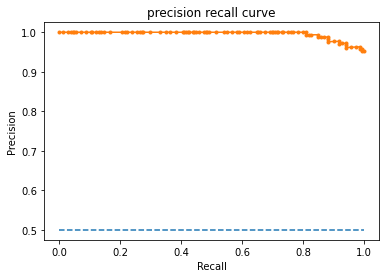

In [32]:
probs,y_test=logistic(X_ran,y_ran)
plot_pre_curve(y_test,probs)

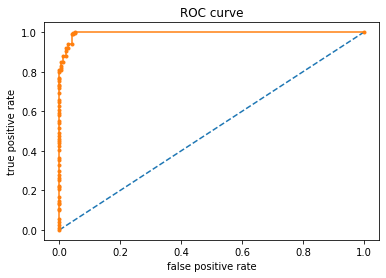

In [33]:
plot_roc(y_test,probs)


## [Under-sampling: Tomek links](#9)

Tomek links are pairs of very close instances, but of opposite classes. Removing the instances of the majority class of each pair increases the space between the two classes, facilitating the classification process.

![](https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/tomek.png?v=2)

In [34]:
from imblearn.under_sampling import TomekLinks
tl = TomekLinks(return_indices=True, ratio='majority')
X_tl, y_tl, id_tl = tl.fit_sample(X, y)
print('Removed indexes:', id_tl)
plot_2d_space(X_tl, y_tl,X,y, 'Tomek links under-sampling')

In [35]:
probs,y_test=logistic(X_tl,y_tl)
plot_pre_curve(y_test,probs)

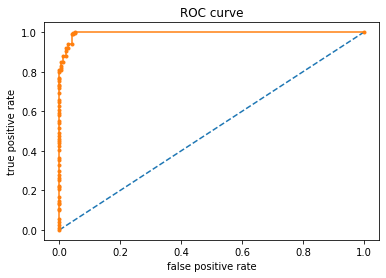

In [36]:
plot_roc(y_test,probs)

<div align='left'><font size='4' color=' #6c3483'>  Over-sampling: SMOTE </font></div>







SMOTE (Synthetic Minority Oversampling TEchnique) consists of synthesizing elements for the minority class, based on those that already exist. It works randomly picingk a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.

![](https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/smote.png)


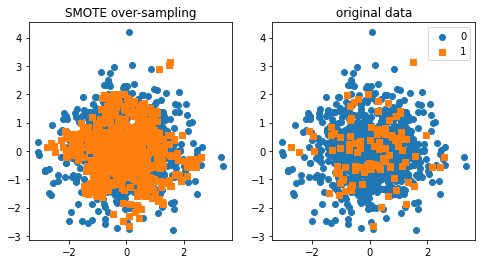

In [37]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_sample(X, y)

plot_2d_space(X_sm, y_sm,X,y, 'SMOTE over-sampling')

Let's try fit and predict on this data and observe the outcome.

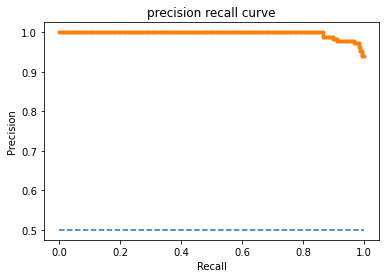

In [38]:
probs,y_test=logistic(X_sm,y_sm)
plot_pre_curve(y_test,probs)

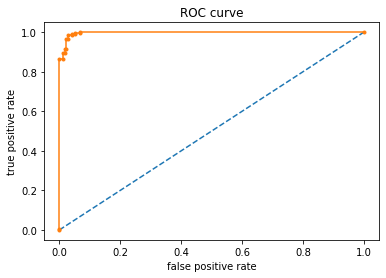

In [39]:
plot_roc(y_test,probs)

## [Algorithmic Ensemble Techniques - Zining Han](#11)<a id="11"></a> <br>

The above section, deals with handling imbalanced data by resampling original data to provide balanced classes. In this section, we are going to look at an alternate approach i.e.  Modifying existing classification algorithms to make them appropriate for imbalanced data sets.

The main objective of ensemble methodology is to improve the performance of single classifiers. The approach involves constructing several two stage classifiers from the original data and then aggregate their prediction

![ Approach to Ensemble based Methodologies](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/03/16142904/ICP4.png)

<div align='left'><font size='4' color=' #6c3483'>  XGBoost </font></div>



![](https://miro.medium.com/max/1400/1*FLshv-wVDfu-i54OqvZdHg.png)

XGBoost (Extreme Gradient Boosting) is an advanced and more efficient implementation of Gradient Boosting Algorithm discussed in the previous section.

Advantages over Other Boosting Techniques

It is 10 times faster than the normal Gradient Boosting as it implements parallel processing. It is highly flexible as users can define custom optimization objectives and evaluation criteria, has an inbuilt mechanism to handle missing values.
Unlike gradient boosting which stops splitting a node as soon as it encounters a negative loss, XG Boost splits up to the maximum depth specified and prunes the tree backward and removes splits beyond which there is an only negative loss.

Extreme gradient boosting can be done using the XGBoost package in R and Python

In [107]:
%%time
from sklearn import preprocessing
train_transaction = pd.read_csv('input/train_transaction.csv', index_col='TransactionID')
test_transaction = pd.read_csv('input/test_transaction.csv', index_col='TransactionID')

train_identity = pd.read_csv('input/train_identity.csv', index_col='TransactionID')
test_identity = pd.read_csv('input/test_identity.csv', index_col='TransactionID')

train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)
y_train = train['isFraud'].copy()
# Drop target, fill in NaNs
X_train = train.drop('isFraud', axis=1)
X_test = test.copy()

X_train = X_train.fillna(-999)
X_test = X_test.fillna(-999)

# Label Encoding
for f in X_train.columns:
    if X_train[f].dtype=='object' or X_test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values) + list(X_test[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))
        X_test[f] = lbl.transform(list(X_test[f].values)) 

CPU times: user 1min 26s, sys: 49.7 s, total: 2min 15s
Wall time: 2min 55s


In [117]:
import xgboost as xgb
clf = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=9,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    missing=-999,
    random_state=2019
    #tree_method='gpu_hist'  # THE MAGICAL PARAMETER 
    # MAC not supported
)

In [ ]:
%time 
clf.fit(X_train, y_train)

### WORK IN PROGRESS
<div align='left'><font size='5' color=' #a93226 '> 

<div align='left'><font size='4' color=' #6c3483'> References </font></div>


- [Dealing with Imbalanced Data](https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18)
- [Resampling strategies for imbalanced datasets](https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets)

In [40]:
print('Time elapsed: ', datetime.now() - start_time)

Time elapsed:  0:06:33.208589
